In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pickle
import matplotlib
import ipyparams
        
path = os.getcwd().split(os.sep + 'GUI')[0]
if path not in sys.path:
    print("not here")
    sys.path.append(path)

from neurolib_dev_optControl.neurolib.models.aln import ALNModel
from neurolib_dev_optControl.neurolib.utils import plotFunctions as plotFunc
from neurolib_dev_optControl.neurolib.utils import func_optimize as fo
from neurolib_dev_optControl.neurolib.utils import costFunctions as cost
import neurolib_dev_optControl.neurolib.dashboard.functions as functions
import neurolib_dev_optControl.neurolib.dashboard.data as data
import neurolib_dev_optControl.neurolib.dashboard.layout as layout
    
# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2 

#path = os.path.join(os.getcwd(), "plots")

cmap_ = layout.getcolormap()
darkgrey, midgrey, lightgrey, color_bi_updown, color_LC, color_bi_uposc = layout.getcolors_rgba()
exc_red = cmap_(3)
inh_blue=cmap_(0)
green = cmap_(2)

<IPython.core.display.Javascript object>

In [2]:
aln = ALNModel()
N = aln.params.N

aln.params.sigma_ou = 0.
aln.params.mue_ext_mean = 0.
aln.params.mui_ext_mean = 0.
aln.params.ext_exc_current = 0.
aln.params.ext_inh_current = 0.

state_vars = aln.state_vars
init_vars = aln.init_vars

##############################################################
def setinit(init_vars_, model):
    state_vars = model.state_vars
    init_vars = model.init_vars
    for iv in range(len(init_vars)):
        for sv in range(len(state_vars)):
            if state_vars[sv] in init_vars[iv]:
                #print("set init vars ", )
                if model.params[init_vars[iv]].ndim == 2:
                    model.params[init_vars[iv]][0,:] = init_vars_[sv]
                else:
                    model.params[init_vars[iv]][0] = init_vars_[sv]
                    
##############################################################               
def setmaxmincontrol(max_c_c, min_c_c, max_c_r, min_c_r):
    import numpy as np
    
    max_cntrl = np.zeros(( 6 ))
    min_cntrl = np.zeros(( 6 ))
    
    max_cntrl[0] = max_c_c
    min_cntrl[0] = min_c_c
    max_cntrl[1] = max_c_c
    min_cntrl[1] = min_c_c
    max_cntrl[2] = max_c_r
    min_cntrl[2] = min_c_r
    max_cntrl[3] = max_c_r
    min_cntrl[3] = min_c_r
    max_cntrl[4] = max_c_r
    min_cntrl[4] = min_c_r
    max_cntrl[5] = max_c_r
    min_cntrl[5] = min_c_r
            
    return max_cntrl, min_cntrl

def rep_ind(c0, c1):
    abs_diff = np.abs(c0-c1)
    res = 0.
    for n in range(c0.shape[0]):
        for v in range(c0.shape[1]):
            res += sum(abs_diff[n,v,:]) * dt
            
    return res

In [3]:
points = np.array( [ [0.86, 0.25] ])

# 10 points, two costs, 4 methods, N 

In [4]:
def create_dict(task, point, cost_params, init, init_vars, target, sigma_array, N_max_array, it_array):
    return dict( {'task':task, 'point':point, 'cost_params':cost_params, 'init':init, 'init_vars':init_vars,
            'target':target, 'sigma':sigma_array, 'N_array':N_max_array, 'it_array':it_array,
            'cost':np.zeros(( len(sigma_array), 4, 2, len(N_max_array), len(it_array) )),
            'rep_ind':np.zeros(( len(sigma_array), 4, 2, len(N_max_array), len(it_array) ))     } )

params_list = ['task', 'point', 'cost_params', 'init', 'init_vars', 'target', 'sigma', 'N_array',
               'cost', 'rep_ind']

In [5]:
dict_list = []
sigma_array = np.arange(0.01, 0.081, 0.02)
N_array = [2,10,30,50]
it_array = np.arange(0,25,6)

for p in points:
    dict_list.append(create_dict('DU', p, [None]*len(sigma_array), [0], None,
                [None]*len(sigma_array), sigma_array, N_array, it_array) )

In [8]:
for d in dict_list:
    print(d['target'])

[array([[[ 3.0419861,  3.0419861,  3.0419861, ...,  3.0419861,
          3.0419861,  3.0419861],
        [15.191433 , 15.191433 , 15.191433 , ..., 15.191433 ,
         15.191433 , 15.191433 ]]]), array([[[ 3.0419861,  3.0419861,  3.0419861, ...,  3.0419861,
          3.0419861,  3.0419861],
        [15.191433 , 15.191433 , 15.191433 , ..., 15.191433 ,
         15.191433 , 15.191433 ]]]), array([[[ 3.0419861,  3.0419861,  3.0419861, ...,  3.0419861,
          3.0419861,  3.0419861],
        [15.191433 , 15.191433 , 15.191433 , ..., 15.191433 ,
         15.191433 , 15.191433 ]]]), array([[[ 3.0419861,  3.0419861,  3.0419861, ...,  3.0419861,
          3.0419861,  3.0419861],
        [15.191433 , 15.191433 , 15.191433 , ..., 15.191433 ,
         15.191433 , 15.191433 ]]])]


In [7]:
dict_file = "UD_1E.pickle"

if False:
    file=open(dict_file, "wb")
    pickle.dump(dict_list, file)
    file.close()

if True:
    file = open(dict_file, "rb")
    dict_list = pickle.load(file)
    file.close()

In [10]:
dur_pre = 10
dur_post = 10
dur = 500.
dur_comp = 2000.
dt = aln.params.dt
T = int(1 + dur / dt)

prec_vars = [0,1]
trans_time = 0.6

n_pre = int(np.around(dur_pre/aln.params.dt,1))
n_post = int(np.around(dur_post/aln.params.dt,1))

tol = 1e-16
start_step = 10.
c_scheme = np.zeros(( 1,1 ))
c_scheme[0,0] = 1.
u_mat = np.identity(1)
u_scheme = np.array([[1.]])

maxC = [5., -5., 0.18, 0.]
n_dur = int(np.around(dur/aln.params.dt + 1.,1))
max_cntrl, min_cntrl = setmaxmincontrol(maxC[0], maxC[1], maxC[2], maxC[3])

noise_realizations_final = 10000
dur_target_compute = 100000
init_it = 3

Point =  [0.86 0.25]


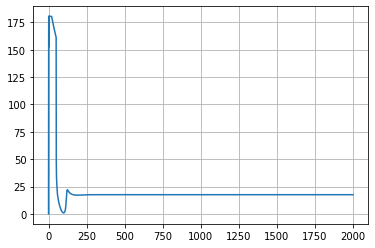

In [9]:
# get init vars without noise
aln.params.duration = dur_comp

# initial without noise
control0 = aln.getZeroControl()

for d in dict_list:
    
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    aln.params.duration = dur_comp
    aln.params.sigma_ou = 0.
    
    control0[0,0,:500] = 5.

    aln.run(control=control0)

    plt.plot(aln.t, aln.rates_exc[0,:])
    plt.show() 

    init_state_vars = np.zeros(( len(state_vars) ))
    for j in range(len(state_vars)):
        if aln.state[state_vars[j]].size == 1:
            init_state_vars[j] = aln.state[state_vars[j]][0]
        else:
            init_state_vars[j] = aln.state[state_vars[j]][0,-1]

    initVars = init_state_vars.copy()
    d['init_vars'] = initVars

Point =  [0.86 0.25]


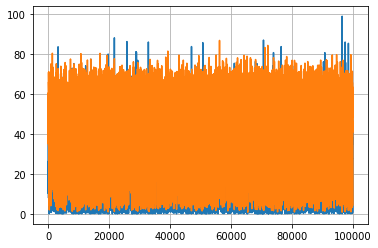

[ 3.0419861 15.191433 ]
0.0004517907010954736


In [13]:
for d in dict_list:
    
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
        
    aln.params.sigma_ou = 0.15
    aln.params.duration = dur_target_compute

    setinit(d['init_vars'], aln)

    target_rates_e = []
    target_rates_i = []

    aln.run(control=aln.getZeroControl())
    for t in range(len(aln.t)):
        if aln.rates_exc[0,t] > 10.:
            continue
        if aln.rates_inh[0,t] > 30.:
            continue

        target_rates_e.append(aln.rates_exc[0,t])
        target_rates_i.append(aln.rates_inh[0,t])

    plt.plot(aln.t, aln.rates_exc[0,:])
    #plt.plot(aln.t, aln.rates_inh[0,:])
    plt.show()            

    aln.params.duration = dur
    target = aln.getZeroTarget()
    target[:,0,:] = np.mean(target_rates_e)
    target[:,1,:] = np.mean(target_rates_i)
    stddev = np.std(target_rates_e) + np.std(target_rates_i)
        
    for ind_s in range(len(d['sigma'])): 
        
        d['target'][ind_s] = target
        d['cost_params'][ind_s] = [1. / ( stddev * (1. - trans_time) * dur ), 0., 1.]
        
        
    print(d['target'][0][0,:,-1])
    print(d['cost_params'][0][0])
        
    file=open(dict_file, "wb")
    pickle.dump(dict_list, file)
    file.close()
    
    

In [11]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 1
method_ind = 0
step_method_ind = 0

for d in dict_list:
        
        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):
        
        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        aln.params.duration = dur
        zero_init = aln.getZeroControl()
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
        
        if np.amin(d['cost'][s_ind, method_ind, step_method_ind, :, 0]) == 0.:
        
            setinit(d['init_vars'], aln)
            cost_final = 0.

            for n_ in range(noise_realizations_final):
                state_ = fo.updateState(aln, zero_init)
                cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                               state_, target_, list(prec_vars) )

            d['cost'][s_ind, :, :, :, 0] = cost_final/noise_realizations_final
            
        print('cost = ', d['cost'][s_ind, 0, 0, 0])    
        
        for i_it in range(1,len(d['it_array'])):
            
            it = d['it_array'][i_it]
            print("iteration = ", it)
        
            for n_ind in range(len(d['N_array'])):

                if ( d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.
                    and d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0. ) :
                    continue
                    
                n_max = d['N_array'][n_ind]
                print("n max = ", n_max)

                aln.params.duration = dur
                     
                    
                n_ = 0
                control_sum = aln.getZeroControl()
                
                while n_ < n_max:
                
                    print('--------', n_)

                    aln.params.duration = dur
                    control_init = aln.getZeroControl()               
                    setinit(d['init_vars'], aln)
                    
                    c_vars = d['init']

                    bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                        control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                        control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                        noise_real=0, init_params = d['init_vars'])
                    
                    if np.isnan(c_).any():
                        continue
                    
                    control_init = bc[:,:,n_pre:-n_post]
                    c_vars = [0,1]
                    aln.params.duration = dur
                    setinit(d['init_vars'], aln)
                    
                    bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                        control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = it-init_it,
                        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                        control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                        noise_real=0, init_params = d['init_vars'])
                    
                    if np.isnan(c_).any():
                        continue
                    
                    control_sum += bc[:,:,n_pre:-n_post]
                    n_ += 1

                control_init = control_sum / n_max
        
                aln.params.duration = dur
                setinit(d['init_vars'], aln)

                cost_final = 0.

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )
                    cost_final += cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2],
                                                                   dt, control_init)

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = cost_final/noise_realizations_final
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                ###############################################################
                
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                     
                    
                n_ = 0
                control_sum = aln.getZeroControl()
                
                while n_ < n_max:
                
                    print('--------', n_)

                    aln.params.duration = dur
                    control_init1 = aln.getZeroControl()               
                    setinit(d['init_vars'], aln)
                    
                    c_vars = d['init']

                    bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                        control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                        control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                        noise_real=0, init_params = d['init_vars'])
                    
                    if np.isnan(c_).any():
                        continue
                    
                    control_init1 = bc[:,:,n_pre:-n_post]
                    c_vars = [0,1]
                    aln.params.duration = dur
                    setinit(d['init_vars'], aln)
                    
                    bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                        control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = it-init_it,
                        tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                        t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                        control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                        noise_real=0, init_params = d['init_vars'])
                    
                    if np.isnan(c_).any():
                        continue
                    
                    control_sum += bc[:,:,n_pre:-n_post]
                    n_ += 1

                control_init1 = control_sum / n_max
                
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()

Point =  [0.86 0.25]
sigma =  0.01
set cost params:  0.0004517907010954736 0.0 1.0
cost =  [62.47333142 15.31951424 14.23395801 13.31574011 13.42083177]
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.03
set cost params:  0.0004517907010954736 0.0 1.0
cost =  [62.07363298 20.14123332 16.97587267 19.77401592 15.48801383]
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.049999999999999996
set cost params:  0.0004517907010954736 0.0 1.0
cost =  [61.17569501 18.47502343 16.49212027 18.9589911  18.81081706]
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.06999999999999999
set cost params:  0.0004517907010954736 0.0 1.0
cost =  [60.69938789 25.19504408 32.08345308 20.3008882  20.23994875]
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n max =  10
-------- 0
interpolate adjoint :  True True True
initial cost =  60.733738846869315
RUN  0 , total integrated cost =  60.733738846869315
Gradient descend me

RUN  3 , total integrated cost =  18.513252219478545
RUN  3 , total integrated cost =  18.513252219478545
Improved over  3  iterations in  0.22565344700001333  seconds by  69.50399158689711  percent.
interpolate adjoint :  True True True
initial cost =  16.50646793520931
RUN  0 , total integrated cost =  16.50646793520931
Gradient descend method:  None
RUN  1 , total integrated cost =  15.034884580903704
RUN  2 , total integrated cost =  14.18616597155242
RUN  3 , total integrated cost =  14.5300202834864
RUN  4 , total integrated cost =  15.914462152650728
RUN  5 , total integrated cost =  14.637944142975716
RUN  6 , total integrated cost =  15.400606699767945
RUN  7 , total integrated cost =  15.514199604925277
RUN  8 , total integrated cost =  15.97893805123277
RUN  9 , total integrated cost =  15.797958338014263
RUN  10 , total integrated cost =  15.993927950046558
RUN  11 , total integrated cost =  15.62035853617728
RUN  12 , total integrated cost =  15.417340712046842
RUN  13 , t

RUN  1 , total integrated cost =  22.291729127712273
RUN  2 , total integrated cost =  19.18237823969109
RUN  3 , total integrated cost =  17.752699982578857
RUN  3 , total integrated cost =  17.752699982578857
Improved over  3  iterations in  0.3186187329999939  seconds by  72.93892999284505  percent.
interpolate adjoint :  True True True
initial cost =  28.137387448442652
RUN  0 , total integrated cost =  28.137387448442652
Gradient descend method:  None
RUN  1 , total integrated cost =  16.502404438917953
RUN  2 , total integrated cost =  16.565766378377685
RUN  3 , total integrated cost =  14.762387502264875
RUN  4 , total integrated cost =  16.03585362168743
RUN  5 , total integrated cost =  14.644523763264836
RUN  6 , total integrated cost =  14.198544654830846
RUN  7 , total integrated cost =  15.266414240182506
RUN  8 , total integrated cost =  17.17847396231782
RUN  9 , total integrated cost =  14.431360931411135
RUN  10 , total integrated cost =  15.586888122074056
RUN  11 , 

/home/lena/.local/lib/python3.9/site-packages/numba/core/ir_utils.py:2119: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'var_' of function 'numba_cost_precision_int'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../../../../../neurolib/utils/costFunctions.py", line 79:
@numba.njit
def numba_cost_precision_int(N, T, dt, i_p, state_, target_state_, var_):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


cost =  17.737295064859172
-------- 0
interpolate adjoint :  True True True
initial cost =  63.08679796039959
RUN  0 , total integrated cost =  63.08679796039959
Gradient descend method:  None
RUN  1 , total integrated cost =  34.41277458089247
RUN  2 , total integrated cost =  25.18919434465674
RUN  3 , total integrated cost =  20.544321691051316
RUN  3 , total integrated cost =  20.544321691051316
Improved over  3  iterations in  0.2610314800001561  seconds by  67.43483208016477  percent.
interpolate adjoint :  True True True
initial cost =  33.63176403861942
RUN  0 , total integrated cost =  33.63176403861942
Gradient descend method:  None
RUN  1 , total integrated cost =  21.07747999056163
RUN  2 , total integrated cost =  18.985579388170702
RUN  3 , total integrated cost =  13.452114421595997
RUN  4 , total integrated cost =  16.09242617363824
RUN  5 , total integrated cost =  18.387509069457295
RUN  6 , total integrated cost =  19.315152230721036
RUN  7 , total integrated cost = 

RUN  6 , total integrated cost =  15.993593190756375
RUN  7 , total integrated cost =  16.64147089236959
RUN  8 , total integrated cost =  15.808438973174853
RUN  9 , total integrated cost =  16.62538852520961
RUN  10 , total integrated cost =  16.677292292056705
RUN  11 , total integrated cost =  16.167060014511748
RUN  12 , total integrated cost =  16.38027812533789
RUN  13 , total integrated cost =  17.80732647446058
RUN  14 , total integrated cost =  16.51767768947772
RUN  15 , total integrated cost =  16.509101173715713
RUN  16 , total integrated cost =  16.649927468015346
RUN  17 , total integrated cost =  16.573998053977466
RUN  18 , total integrated cost =  17.6859104739624
RUN  19 , total integrated cost =  16.666555291353625
RUN  20 , total integrated cost =  16.95811630711129
RUN  21 , total integrated cost =  16.594211180433867
Improved over  21  iterations in  6.3323775130002105  seconds by  25.65767347792709  percent.
-------- 5
interpolate adjoint :  True True True
initi

RUN  2 , total integrated cost =  33.91616381549156
Control only changes marginally.
RUN  2 , total integrated cost =  33.91616381549156
Improved over  2  iterations in  0.3802420870001697  seconds by  45.46192685314195  percent.
interpolate adjoint :  True True True
initial cost =  33.02652378374235
RUN  0 , total integrated cost =  33.02652378374235
Gradient descend method:  None
RUN  1 , total integrated cost =  29.759126469668637
RUN  2 , total integrated cost =  32.980179620945485
RUN  3 , total integrated cost =  25.567280808907938
RUN  4 , total integrated cost =  25.161410464524863
RUN  5 , total integrated cost =  19.42319350361064
RUN  6 , total integrated cost =  24.705171704319227
RUN  7 , total integrated cost =  21.05027187652449
RUN  8 , total integrated cost =  24.81022101454764
RUN  9 , total integrated cost =  19.98192880190057
RUN  10 , total integrated cost =  16.371286907292546
RUN  11 , total integrated cost =  20.387926150261617
RUN  12 , total integrated cost = 

step size too small or too large
RUN  2 , total integrated cost =  43.46660407587027
Control only changes marginally.
RUN  2 , total integrated cost =  43.46660407587027
Improved over  2  iterations in  0.31091658699961044  seconds by  37.19499130422407  percent.
interpolate adjoint :  True True True
initial cost =  46.530463403110915
RUN  0 , total integrated cost =  46.530463403110915
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  46.530463403110915
Control only changes marginally.
RUN  1 , total integrated cost =  46.530463403110915
Improved over  1  iterations in  0.5543115629998283  seconds by  0.0  percent.
-------- 5
interpolate adjoint :  True True True
initial cost =  47.11008857220138
RUN  0 , total integrated cost =  47.11008857220138
Gradient descend method:  None
RUN  1 , total integrated cost =  44.56690856385157
RUN  2 , total integrated cost =  22.2236626

RUN  1 , total integrated cost =  44.85749911533446
RUN  2 , total integrated cost =  44.27454893680384
RUN  3 , total integrated cost =  32.80190201648502
RUN  3 , total integrated cost =  32.80190201648502
Improved over  3  iterations in  0.2882093490002262  seconds by  42.83447424758414  percent.
interpolate adjoint :  True True True
initial cost =  41.76180267416438
RUN  0 , total integrated cost =  41.76180267416438
Gradient descend method:  None
RUN  1 , total integrated cost =  29.612126382531006
RUN  2 , total integrated cost =  26.058054067926946
RUN  3 , total integrated cost =  18.107895063760736
RUN  4 , total integrated cost =  16.84744897597287
RUN  5 , total integrated cost =  13.074171425781298
RUN  6 , total integrated cost =  15.415414657650938
RUN  7 , total integrated cost =  13.904997604975684
RUN  8 , total integrated cost =  13.002793791608571
RUN  9 , total integrated cost =  18.276007985989303
RUN  10 , total integrated cost =  16.108835124308907
RUN  11 , tota

RUN  10 , total integrated cost =  24.34333856169438
RUN  11 , total integrated cost =  24.53494899206062
RUN  12 , total integrated cost =  25.367480380114394
RUN  13 , total integrated cost =  25.268795479443146
RUN  14 , total integrated cost =  24.488258194911246
RUN  15 , total integrated cost =  25.41041479630566
RUN  16 , total integrated cost =  24.663737140372092
RUN  17 , total integrated cost =  24.975138387754463
RUN  18 , total integrated cost =  25.00451135765935
RUN  19 , total integrated cost =  25.46743808011406
RUN  20 , total integrated cost =  24.512713502728477
RUN  21 , total integrated cost =  25.514025210173784
Improved over  21  iterations in  3.72571206900011  seconds by  26.820471820889324  percent.
-------- 14
interpolate adjoint :  True True True
initial cost =  60.56376406625959
RUN  0 , total integrated cost =  60.56376406625959
Gradient descend method:  None
RUN  1 , total integrated cost =  48.94750945538075
RUN  2 , total integrated cost =  39.74282337

RUN  9 , total integrated cost =  31.181286774792667
RUN  10 , total integrated cost =  28.70981469512956
RUN  11 , total integrated cost =  29.791618612363102
RUN  12 , total integrated cost =  21.863996504746552
RUN  13 , total integrated cost =  27.817382186312564
RUN  14 , total integrated cost =  23.949720856050618
RUN  15 , total integrated cost =  18.653610971020612
RUN  16 , total integrated cost =  16.80315468727924
RUN  17 , total integrated cost =  20.44385818405188
RUN  18 , total integrated cost =  17.384162647567166
RUN  19 , total integrated cost =  21.67187179409782
RUN  20 , total integrated cost =  21.85448696413924
RUN  21 , total integrated cost =  27.50600020520893
Improved over  21  iterations in  4.359264545999849  seconds by  44.96029774384505  percent.
-------- 19
interpolate adjoint :  True True True
initial cost =  61.82360386041446
RUN  0 , total integrated cost =  61.82360386041446
Gradient descend method:  None
RUN  1 , total integrated cost =  45.03103253

RUN  2 , total integrated cost =  24.08015993949325
RUN  3 , total integrated cost =  23.907448686147184
RUN  4 , total integrated cost =  23.59388297626692
RUN  5 , total integrated cost =  23.73665227257492
RUN  6 , total integrated cost =  24.055382267293716
RUN  7 , total integrated cost =  23.357959279263333
RUN  8 , total integrated cost =  22.165250953836193
RUN  9 , total integrated cost =  21.52274845345855
RUN  10 , total integrated cost =  22.21235046996273
RUN  11 , total integrated cost =  21.978587878799537
RUN  12 , total integrated cost =  21.953824708695855
RUN  13 , total integrated cost =  21.819816816577386
RUN  14 , total integrated cost =  21.504781773730976
RUN  15 , total integrated cost =  20.75484101072479
RUN  16 , total integrated cost =  20.824855603320618
RUN  17 , total integrated cost =  20.088229800994668
RUN  18 , total integrated cost =  19.884384966187422
RUN  19 , total integrated cost =  19.40594387356946
RUN  20 , total integrated cost =  18.87369

RUN  19 , total integrated cost =  22.044260575554834
RUN  20 , total integrated cost =  19.184246167087515
RUN  21 , total integrated cost =  21.44941161772916
Improved over  21  iterations in  4.672356603000026  seconds by  62.39184600979195  percent.
-------- 28
interpolate adjoint :  True True True
initial cost =  64.01256192992832
RUN  0 , total integrated cost =  64.01256192992832
Gradient descend method:  None
RUN  1 , total integrated cost =  32.76438329647536
RUN  2 , total integrated cost =  31.503056790417492
RUN  3 , total integrated cost =  21.30117936864705
RUN  3 , total integrated cost =  21.30117936864705
Improved over  3  iterations in  0.3302605920002861  seconds by  66.72343876509038  percent.
interpolate adjoint :  True True True
initial cost =  16.262773099219494
RUN  0 , total integrated cost =  16.262773099219494
Gradient descend method:  None
RUN  1 , total integrated cost =  16.17383581416556
RUN  2 , total integrated cost =  16.654551655166166
RUN  3 , total 

RUN  1 , total integrated cost =  24.190436231028123
RUN  2 , total integrated cost =  24.749851228233403
RUN  3 , total integrated cost =  24.931779472934913
RUN  4 , total integrated cost =  21.530984337494328
RUN  5 , total integrated cost =  20.83198753454604
RUN  6 , total integrated cost =  21.66668670746266
RUN  7 , total integrated cost =  21.110253215024976
RUN  8 , total integrated cost =  20.484825961826473
RUN  9 , total integrated cost =  20.573272479155087
RUN  10 , total integrated cost =  20.753773033018305
RUN  11 , total integrated cost =  20.926219981837484
RUN  12 , total integrated cost =  20.70717202481896
RUN  13 , total integrated cost =  20.748435503746094
RUN  14 , total integrated cost =  20.630660135236752
RUN  15 , total integrated cost =  20.691072196608637
RUN  16 , total integrated cost =  20.365447138834686
RUN  17 , total integrated cost =  20.51788497334954
RUN  18 , total integrated cost =  20.671398024941734
RUN  19 , total integrated cost =  20.489

RUN  1 , total integrated cost =  16.47177740239653
RUN  2 , total integrated cost =  15.783608109350313
RUN  3 , total integrated cost =  15.268357309200923
RUN  4 , total integrated cost =  14.891149855106308
RUN  5 , total integrated cost =  15.788506660934
RUN  6 , total integrated cost =  16.049650593168646
RUN  7 , total integrated cost =  15.879145381134888
RUN  8 , total integrated cost =  15.981025334082258
RUN  9 , total integrated cost =  15.976021144692167
RUN  10 , total integrated cost =  15.615635764188287
RUN  11 , total integrated cost =  15.77438874447948
RUN  12 , total integrated cost =  16.139345796283806
RUN  13 , total integrated cost =  16.010556965840422
RUN  14 , total integrated cost =  15.557381424653826
RUN  15 , total integrated cost =  15.70519928459639
RUN  16 , total integrated cost =  15.753368192415074
RUN  17 , total integrated cost =  15.632808391112976
RUN  18 , total integrated cost =  15.16263520639689
RUN  19 , total integrated cost =  14.805308

RUN  17 , total integrated cost =  14.868331970689947
RUN  18 , total integrated cost =  15.580340874123738
RUN  19 , total integrated cost =  13.119629513129533
RUN  20 , total integrated cost =  16.068051417381106
RUN  21 , total integrated cost =  14.225652266442324
Improved over  21  iterations in  7.5547506309999335  seconds by  25.797151886991116  percent.
-------- 12
interpolate adjoint :  True True True
initial cost =  65.70406650309316
RUN  0 , total integrated cost =  65.70406650309316
Gradient descend method:  None
RUN  1 , total integrated cost =  33.01131949773953
RUN  2 , total integrated cost =  27.085381521652607
RUN  3 , total integrated cost =  26.0067285643001
RUN  3 , total integrated cost =  26.0067285643001
Improved over  3  iterations in  0.32715984600008596  seconds by  60.41838816311959  percent.
interpolate adjoint :  True True True
initial cost =  27.93556779045002
RUN  0 , total integrated cost =  27.93556779045002
Gradient descend method:  None
RUN  1 , tot

RUN  18 , total integrated cost =  33.34958080126565
RUN  19 , total integrated cost =  27.1389817949123
RUN  20 , total integrated cost =  25.830759375798653
RUN  21 , total integrated cost =  26.346058373446326
Improved over  21  iterations in  4.350811386999794  seconds by  49.534433009970726  percent.
-------- 17
interpolate adjoint :  True True True
initial cost =  53.94951873230906
RUN  0 , total integrated cost =  53.94951873230906
Gradient descend method:  None
RUN  1 , total integrated cost =  46.20332183238361
RUN  2 , total integrated cost =  38.87518348491823
RUN  3 , total integrated cost =  39.02774423881003
RUN  3 , total integrated cost =  39.02774423881003
Improved over  3  iterations in  0.2919780580000406  seconds by  27.658772208032218  percent.
interpolate adjoint :  True True True
initial cost =  42.95864485245097
RUN  0 , total integrated cost =  42.95864485245097
Gradient descend method:  None
RUN  1 , total integrated cost =  31.037396651322894
RUN  2 , total i

RUN  17 , total integrated cost =  15.640943581889477
RUN  18 , total integrated cost =  16.06998129884135
RUN  19 , total integrated cost =  15.274108122984341
RUN  20 , total integrated cost =  15.425031361279242
RUN  21 , total integrated cost =  15.448681138484218
Improved over  21  iterations in  3.8129757459996654  seconds by  20.808944738342873  percent.
-------- 22
interpolate adjoint :  True True True
initial cost =  68.68511249257044
RUN  0 , total integrated cost =  68.68511249257044
Gradient descend method:  None
RUN  1 , total integrated cost =  26.355987054939433
RUN  2 , total integrated cost =  24.56897970601444
RUN  3 , total integrated cost =  25.760915831522205
RUN  3 , total integrated cost =  25.760915831522205
Improved over  3  iterations in  0.3794334260001051  seconds by  62.49417829182602  percent.
interpolate adjoint :  True True True
initial cost =  25.79446589391022
RUN  0 , total integrated cost =  25.79446589391022
Gradient descend method:  None
RUN  1 , t

RUN  2 , total integrated cost =  24.887872876978097
RUN  3 , total integrated cost =  24.816877097174576
RUN  4 , total integrated cost =  22.472782442812786
RUN  5 , total integrated cost =  22.257503122622268
RUN  6 , total integrated cost =  22.567102717884662
RUN  7 , total integrated cost =  22.413017064584302
RUN  8 , total integrated cost =  22.26168429893395
RUN  9 , total integrated cost =  22.051783017220423
RUN  10 , total integrated cost =  20.034384447315478
RUN  11 , total integrated cost =  20.145484503280656
RUN  12 , total integrated cost =  20.98259918990872
RUN  13 , total integrated cost =  20.121752873313
RUN  14 , total integrated cost =  20.31881464488861
RUN  15 , total integrated cost =  19.788186677922937
RUN  16 , total integrated cost =  18.79593677508979
RUN  17 , total integrated cost =  19.095755575414053
RUN  18 , total integrated cost =  18.57782928715946
RUN  19 , total integrated cost =  18.378001363796127
RUN  20 , total integrated cost =  18.544131

RUN  3 , total integrated cost =  37.40599218703089
RUN  3 , total integrated cost =  37.40599218703089
Improved over  3  iterations in  0.2826205569999729  seconds by  33.33337472117249  percent.
interpolate adjoint :  True True True
initial cost =  41.1366418075621
RUN  0 , total integrated cost =  41.1366418075621
Gradient descend method:  None
RUN  1 , total integrated cost =  35.75201120406072
RUN  2 , total integrated cost =  36.06903810847895
RUN  3 , total integrated cost =  35.55087871379527
RUN  4 , total integrated cost =  34.9962792435675
RUN  5 , total integrated cost =  34.614197483784665
RUN  6 , total integrated cost =  34.81001019643222
RUN  7 , total integrated cost =  35.38961875346971
RUN  8 , total integrated cost =  35.29480383609305
RUN  9 , total integrated cost =  35.041595226348335
RUN  10 , total integrated cost =  35.21441157730947
RUN  11 , total integrated cost =  35.235351416488655
RUN  12 , total integrated cost =  35.412876063617766
RUN  13 , total inte

RUN  11 , total integrated cost =  19.67384163584768
RUN  12 , total integrated cost =  18.30062099590046
RUN  13 , total integrated cost =  19.035781492449296
RUN  14 , total integrated cost =  23.40462854854953
RUN  15 , total integrated cost =  16.92565628181021
RUN  16 , total integrated cost =  19.974943300106688
RUN  17 , total integrated cost =  21.988546156697346
RUN  18 , total integrated cost =  17.339511410894804
RUN  19 , total integrated cost =  14.215844610492184
RUN  20 , total integrated cost =  17.672362391234202
RUN  21 , total integrated cost =  22.641301490410235
Improved over  21  iterations in  3.584231377999913  seconds by  57.80609770321289  percent.
-------- 6
interpolate adjoint :  True True True
initial cost =  62.044365968116836
RUN  0 , total integrated cost =  62.044365968116836
Gradient descend method:  None
RUN  1 , total integrated cost =  31.837444000200435
RUN  2 , total integrated cost =  26.273679893092865
RUN  3 , total integrated cost =  20.270449

RUN  1 , total integrated cost =  52.211679360879934
RUN  2 , total integrated cost =  43.92062443050462
RUN  3 , total integrated cost =  46.42231689804826
RUN  3 , total integrated cost =  46.42231689804826
Improved over  3  iterations in  0.26705833299956794  seconds by  21.24448904100049  percent.
interpolate adjoint :  True True True
initial cost =  56.93331446460216
RUN  0 , total integrated cost =  56.93331446460216
Gradient descend method:  None
RUN  1 , total integrated cost =  45.274761639753855
RUN  2 , total integrated cost =  34.303106789087096
RUN  3 , total integrated cost =  36.109196914206116
RUN  4 , total integrated cost =  39.15821587558584
RUN  5 , total integrated cost =  36.99904014378772
RUN  6 , total integrated cost =  39.336202588483296
RUN  7 , total integrated cost =  36.48263080639163
RUN  8 , total integrated cost =  34.759738130289094
RUN  9 , total integrated cost =  40.4391030914105
RUN  10 , total integrated cost =  38.07670762053129
Control only chan

RUN  19 , total integrated cost =  13.99006441424446
RUN  20 , total integrated cost =  13.174969121889106
RUN  21 , total integrated cost =  13.256144700012312
Improved over  21  iterations in  3.72902457400005  seconds by  57.8832078093498  percent.
-------- 15
interpolate adjoint :  True True True
initial cost =  60.96274469007115
RUN  0 , total integrated cost =  60.96274469007115
Gradient descend method:  None
RUN  1 , total integrated cost =  32.235623775983115
RUN  2 , total integrated cost =  28.55066645777604
RUN  3 , total integrated cost =  21.121978559957917
RUN  3 , total integrated cost =  21.121978559957917
Improved over  3  iterations in  0.29895921499974065  seconds by  65.35264501731334  percent.
interpolate adjoint :  True True True
initial cost =  23.76159349768573
RUN  0 , total integrated cost =  23.76159349768573
Gradient descend method:  None
RUN  1 , total integrated cost =  20.727286444180972
RUN  2 , total integrated cost =  21.12498691642886
RUN  3 , total i

RUN  1 , total integrated cost =  31.312614036055777
RUN  2 , total integrated cost =  30.337347428523074
RUN  3 , total integrated cost =  33.35255813069557
RUN  4 , total integrated cost =  32.05333087021056
RUN  5 , total integrated cost =  31.516111548895765
RUN  6 , total integrated cost =  31.298553880922064
RUN  7 , total integrated cost =  31.46378471233039
RUN  8 , total integrated cost =  33.02963435027584
RUN  9 , total integrated cost =  33.92465067757031
RUN  10 , total integrated cost =  34.75730408288466
RUN  11 , total integrated cost =  32.28908819518503
RUN  12 , total integrated cost =  32.71652904702165
RUN  13 , total integrated cost =  30.464077251285904
RUN  14 , total integrated cost =  30.167397741213406
RUN  15 , total integrated cost =  30.692726935125783
RUN  16 , total integrated cost =  28.43705745299349
RUN  17 , total integrated cost =  30.63907141774571
RUN  18 , total integrated cost =  24.505995959469594
RUN  19 , total integrated cost =  27.523503373

RUN  17 , total integrated cost =  17.783641104988074
RUN  18 , total integrated cost =  17.43783805884644
RUN  19 , total integrated cost =  18.01292606729459
RUN  20 , total integrated cost =  17.421452820872993
RUN  21 , total integrated cost =  17.435272067530065
Improved over  21  iterations in  5.318161025999871  seconds by  60.96469182262305  percent.
-------- 24
interpolate adjoint :  True True True
initial cost =  75.61051471409375
RUN  0 , total integrated cost =  75.61051471409375
Gradient descend method:  None
RUN  1 , total integrated cost =  37.98657725010558
RUN  2 , total integrated cost =  27.93543702191965
RUN  3 , total integrated cost =  30.650539378574422
RUN  3 , total integrated cost =  30.650539378574422
Improved over  3  iterations in  0.8611867489998986  seconds by  59.46259657869889  percent.
interpolate adjoint :  True True True
initial cost =  33.69997035082211
RUN  0 , total integrated cost =  33.69997035082211
Gradient descend method:  None
RUN  1 , total

RUN  17 , total integrated cost =  18.753131759942725
RUN  18 , total integrated cost =  19.479074156826247
RUN  19 , total integrated cost =  13.175735679607186
RUN  20 , total integrated cost =  18.035589955314755
RUN  21 , total integrated cost =  17.602509879716383
Improved over  21  iterations in  4.136944744000175  seconds by  55.25161796137875  percent.
-------- 29
interpolate adjoint :  True True True
initial cost =  58.22781411424957
RUN  0 , total integrated cost =  58.22781411424957
Gradient descend method:  None
RUN  1 , total integrated cost =  48.906224517472985
RUN  2 , total integrated cost =  48.593559062036505
RUN  3 , total integrated cost =  50.012448456956164
RUN  3 , total integrated cost =  50.012448456956164
Improved over  3  iterations in  0.3096290999997109  seconds by  14.109005777159908  percent.
interpolate adjoint :  True True True
initial cost =  53.373767679380435
RUN  0 , total integrated cost =  53.373767679380435
Gradient descend method:  None
RUN  1 

RUN  1 , total integrated cost =  28.176765605546677
RUN  2 , total integrated cost =  22.808884488973277
RUN  3 , total integrated cost =  19.789420738765713
RUN  4 , total integrated cost =  20.966644346955203
RUN  5 , total integrated cost =  17.911406743242274
RUN  6 , total integrated cost =  18.424802092690214
RUN  7 , total integrated cost =  20.694186524635935
RUN  8 , total integrated cost =  16.783360900048258
RUN  9 , total integrated cost =  16.83574956567777
RUN  10 , total integrated cost =  16.43617769143862
RUN  11 , total integrated cost =  16.964788878702592
RUN  12 , total integrated cost =  16.376371253972053
RUN  13 , total integrated cost =  16.726326134666678
RUN  14 , total integrated cost =  16.770250331617298
RUN  15 , total integrated cost =  16.499837692946542
RUN  16 , total integrated cost =  15.677670498950292
RUN  17 , total integrated cost =  16.380228039037164
RUN  18 , total integrated cost =  16.654352801810333
RUN  19 , total integrated cost =  17.0

RUN  17 , total integrated cost =  27.63750353559423
RUN  18 , total integrated cost =  27.462146921255247
RUN  19 , total integrated cost =  27.693931987604202
RUN  20 , total integrated cost =  29.032303325417615
step size too small or too large
RUN  21 , total integrated cost =  28.226414524877498
Improved over  21  iterations in  5.87060451599973  seconds by  -1.73832652808305  percent.
-------- 38
interpolate adjoint :  True True True
initial cost =  66.95193750455286
RUN  0 , total integrated cost =  66.95193750455286
Gradient descend method:  None
RUN  1 , total integrated cost =  50.36087461414593
RUN  2 , total integrated cost =  42.64134252484425
RUN  3 , total integrated cost =  38.711402229779345
RUN  3 , total integrated cost =  38.711402229779345
Improved over  3  iterations in  0.2903797939998185  seconds by  42.1803107234247  percent.
interpolate adjoint :  True True True
initial cost =  37.00069765024361
RUN  0 , total integrated cost =  37.00069765024361
Gradient desc

RUN  11 , total integrated cost =  20.628409767657523
RUN  12 , total integrated cost =  20.30377031030486
RUN  13 , total integrated cost =  22.612199311884297
RUN  14 , total integrated cost =  22.16288242837338
RUN  15 , total integrated cost =  18.067854752844575
RUN  16 , total integrated cost =  17.04384797089223
Control only changes marginally.
RUN  16 , total integrated cost =  17.04384797089223
Improved over  16  iterations in  3.0483707819998926  seconds by  45.112281662675194  percent.
-------- 43
interpolate adjoint :  True True True
initial cost =  56.71979157559323
RUN  0 , total integrated cost =  56.71979157559323
Gradient descend method:  None
RUN  1 , total integrated cost =  54.16148541353281
RUN  2 , total integrated cost =  25.61323635054865
RUN  3 , total integrated cost =  22.50972249947266
RUN  3 , total integrated cost =  22.50972249947266
Improved over  3  iterations in  0.4562409770001068  seconds by  60.31416570092142  percent.
interpolate adjoint :  True Tr

RUN  1 , total integrated cost =  18.2196691529849
RUN  2 , total integrated cost =  19.08478899180521
RUN  3 , total integrated cost =  18.959888200146974
RUN  4 , total integrated cost =  19.164904664491992
RUN  5 , total integrated cost =  19.549324387808664
RUN  6 , total integrated cost =  19.020390247779375
RUN  7 , total integrated cost =  19.255477552530888
RUN  8 , total integrated cost =  19.01281529881458
RUN  9 , total integrated cost =  19.16423930009777
RUN  10 , total integrated cost =  18.74002068561015
RUN  11 , total integrated cost =  19.019955826419608
RUN  12 , total integrated cost =  18.74915941617115
RUN  13 , total integrated cost =  18.628596915964597
RUN  14 , total integrated cost =  18.6066091826642
RUN  15 , total integrated cost =  18.64621866619031
RUN  16 , total integrated cost =  18.639549173292597
RUN  17 , total integrated cost =  18.527450384848184
RUN  18 , total integrated cost =  18.269297845595467
RUN  19 , total integrated cost =  18.519155613

RUN  18 , total integrated cost =  24.71254608819668
RUN  19 , total integrated cost =  25.191275655903596
RUN  20 , total integrated cost =  24.875934241750823
RUN  21 , total integrated cost =  24.84726096316823
Improved over  21  iterations in  4.023215847999836  seconds by  53.20317476636611  percent.
-------- 2
interpolate adjoint :  True True True
initial cost =  59.176633065195226
RUN  0 , total integrated cost =  59.176633065195226
Gradient descend method:  None
RUN  1 , total integrated cost =  46.948430622597435
RUN  2 , total integrated cost =  49.26525556136755
RUN  3 , total integrated cost =  51.464282411984435
RUN  3 , total integrated cost =  51.464282411984435
Improved over  3  iterations in  0.29929258899983324  seconds by  13.032763531365589  percent.
interpolate adjoint :  True True True
initial cost =  53.09235751497372
RUN  0 , total integrated cost =  53.09235751497372
Gradient descend method:  None
RUN  1 , total integrated cost =  43.66007860617109
RUN  2 , tot

RUN  1 , total integrated cost =  31.8904633048402
RUN  2 , total integrated cost =  39.57686953146747
RUN  3 , total integrated cost =  31.674254227024917
RUN  4 , total integrated cost =  27.068149819482965
RUN  5 , total integrated cost =  32.42338019370877
RUN  6 , total integrated cost =  24.93454318445125
RUN  7 , total integrated cost =  20.237977648783442
RUN  8 , total integrated cost =  26.762940249783703
RUN  9 , total integrated cost =  21.650497887601063
RUN  10 , total integrated cost =  16.181732024912797
RUN  11 , total integrated cost =  18.25097145861514
RUN  12 , total integrated cost =  16.971212201515904
RUN  13 , total integrated cost =  15.090245132815632
RUN  14 , total integrated cost =  21.69837584035497
RUN  15 , total integrated cost =  20.22090364136109
RUN  16 , total integrated cost =  18.542338550372182
RUN  17 , total integrated cost =  17.925922860581295
RUN  18 , total integrated cost =  20.41604782915382
RUN  19 , total integrated cost =  18.70265532

RUN  1 , total integrated cost =  34.650809999842416
RUN  2 , total integrated cost =  33.01495042162064
RUN  3 , total integrated cost =  23.749530685936598
RUN  4 , total integrated cost =  22.53583907220772
RUN  5 , total integrated cost =  21.121533791009007
RUN  6 , total integrated cost =  20.451159374358838
RUN  7 , total integrated cost =  20.820354202418955
RUN  8 , total integrated cost =  21.555440301783598
RUN  9 , total integrated cost =  20.89825736427678
RUN  10 , total integrated cost =  20.224453993005476
RUN  11 , total integrated cost =  18.060849212786223
RUN  12 , total integrated cost =  18.41274210462707
RUN  13 , total integrated cost =  20.40745324649012
RUN  14 , total integrated cost =  19.27170643084176
RUN  15 , total integrated cost =  17.591898025654675
RUN  16 , total integrated cost =  17.354764735299007
RUN  17 , total integrated cost =  19.73966798575748
RUN  18 , total integrated cost =  18.874670838134037
RUN  19 , total integrated cost =  18.626373

RUN  3 , total integrated cost =  23.23078506601765
RUN  3 , total integrated cost =  23.23078506601765
Improved over  3  iterations in  0.31119940899998255  seconds by  57.666206526953715  percent.
interpolate adjoint :  True True True
initial cost =  31.49059233299051
RUN  0 , total integrated cost =  31.49059233299051
Gradient descend method:  None
RUN  1 , total integrated cost =  18.933021579822146
RUN  2 , total integrated cost =  20.278596601584326
RUN  3 , total integrated cost =  17.036584441909845
RUN  4 , total integrated cost =  17.811415468739835
RUN  5 , total integrated cost =  17.363548137595963
RUN  6 , total integrated cost =  17.731110852930698
RUN  7 , total integrated cost =  16.962068508729473
RUN  8 , total integrated cost =  17.196417513819302
RUN  9 , total integrated cost =  17.08150234408514
RUN  10 , total integrated cost =  17.222202731282245
RUN  11 , total integrated cost =  17.021014185545148
RUN  12 , total integrated cost =  16.92813228634857
RUN  13 ,

RUN  11 , total integrated cost =  19.00142959252031
RUN  12 , total integrated cost =  18.860276307504865
RUN  13 , total integrated cost =  17.233788819831148
RUN  14 , total integrated cost =  17.330279945673567
RUN  15 , total integrated cost =  16.784973159003993
RUN  16 , total integrated cost =  16.97780836891193
RUN  17 , total integrated cost =  17.4714506708615
RUN  18 , total integrated cost =  16.93663010372061
RUN  19 , total integrated cost =  17.42302429127357
RUN  20 , total integrated cost =  16.982980859662096
RUN  21 , total integrated cost =  16.85569943974643
Improved over  21  iterations in  3.6776340369997342  seconds by  23.43190988587419  percent.
-------- 21
interpolate adjoint :  True True True
initial cost =  54.53473038061864
RUN  0 , total integrated cost =  54.53473038061864
Gradient descend method:  None
RUN  1 , total integrated cost =  52.10059921655528
RUN  2 , total integrated cost =  26.681389140423818
RUN  3 , total integrated cost =  25.4875642987

RUN  1 , total integrated cost =  36.96683796430955
RUN  2 , total integrated cost =  30.68292399415687
RUN  3 , total integrated cost =  30.49165627454393
RUN  3 , total integrated cost =  30.49165627454393
Improved over  3  iterations in  0.3020617540000785  seconds by  56.33455836154823  percent.
interpolate adjoint :  True True True
initial cost =  29.408129089672034
RUN  0 , total integrated cost =  29.408129089672034
Gradient descend method:  None
RUN  1 , total integrated cost =  21.909860647041967
RUN  2 , total integrated cost =  23.772078660435753
RUN  3 , total integrated cost =  22.01037526981385
RUN  4 , total integrated cost =  22.186035635599957
RUN  5 , total integrated cost =  21.969058492746512
RUN  6 , total integrated cost =  22.21940632678434
RUN  7 , total integrated cost =  22.30382068785451
RUN  8 , total integrated cost =  20.369636519934588
RUN  9 , total integrated cost =  21.176753010979134
RUN  10 , total integrated cost =  21.73691313193367
RUN  11 , total

RUN  9 , total integrated cost =  19.90212282128652
RUN  10 , total integrated cost =  22.337991766858746
RUN  11 , total integrated cost =  29.546212944503434
RUN  12 , total integrated cost =  22.950716431177206
RUN  13 , total integrated cost =  20.014467448333324
RUN  14 , total integrated cost =  19.77690759154998
RUN  15 , total integrated cost =  20.011764370514182
RUN  16 , total integrated cost =  21.584176314984347
RUN  17 , total integrated cost =  22.28378538292912
RUN  18 , total integrated cost =  18.704168610460066
RUN  19 , total integrated cost =  18.200443613595752
RUN  20 , total integrated cost =  23.114061561187096
RUN  21 , total integrated cost =  24.395798741846573
Improved over  21  iterations in  4.37010207000003  seconds by  30.066178466045002  percent.
-------- 30
interpolate adjoint :  True True True
initial cost =  56.986974547944634
RUN  0 , total integrated cost =  56.986974547944634
Gradient descend method:  None
RUN  1 , total integrated cost =  48.385

RUN  2 , total integrated cost =  57.64407767551135
RUN  3 , total integrated cost =  51.442525468838106
RUN  3 , total integrated cost =  51.442525468838106
Improved over  3  iterations in  0.4411328270002741  seconds by  21.012933842028886  percent.
interpolate adjoint :  True True True
initial cost =  59.803740033406044
RUN  0 , total integrated cost =  59.803740033406044
Gradient descend method:  None
RUN  1 , total integrated cost =  49.10831057090437
RUN  2 , total integrated cost =  51.168414405011504
RUN  3 , total integrated cost =  45.755161137414646
RUN  4 , total integrated cost =  52.64560225106051
RUN  5 , total integrated cost =  46.100049742651095
RUN  6 , total integrated cost =  45.02329825855747
RUN  7 , total integrated cost =  42.709269896639896
RUN  8 , total integrated cost =  41.57713450441203
RUN  9 , total integrated cost =  28.485201096034668
RUN  10 , total integrated cost =  23.916313737597385
RUN  11 , total integrated cost =  14.653940768815708
RUN  12 , 

RUN  10 , total integrated cost =  22.955008766349728
RUN  11 , total integrated cost =  23.167222229688285
RUN  12 , total integrated cost =  22.3155660070661
RUN  13 , total integrated cost =  24.848603702500853
RUN  14 , total integrated cost =  17.29931411707207
RUN  15 , total integrated cost =  21.132010552399503
RUN  16 , total integrated cost =  21.348010640620362
RUN  17 , total integrated cost =  17.804565252967738
RUN  18 , total integrated cost =  16.093429843279704
RUN  19 , total integrated cost =  18.500947100714704
RUN  20 , total integrated cost =  18.0806683934758
RUN  21 , total integrated cost =  17.05908010966678
Improved over  21  iterations in  3.4558019880000757  seconds by  64.14946787026861  percent.
-------- 39
interpolate adjoint :  True True True
initial cost =  44.972488968941356
RUN  0 , total integrated cost =  44.972488968941356
Gradient descend method:  None
RUN  1 , total integrated cost =  43.484824069197224
RUN  2 , total integrated cost =  25.82452

RUN  1 , total integrated cost =  21.263364075358073
RUN  2 , total integrated cost =  24.498977605384514
RUN  3 , total integrated cost =  21.407243064282365
RUN  3 , total integrated cost =  21.407243064282365
Improved over  3  iterations in  0.2785837999999785  seconds by  65.88410252791996  percent.
interpolate adjoint :  True True True
initial cost =  21.628198601573555
RUN  0 , total integrated cost =  21.628198601573555
Gradient descend method:  None
RUN  1 , total integrated cost =  20.880062425693378
RUN  2 , total integrated cost =  20.828260351083795
RUN  3 , total integrated cost =  21.069850623435254
RUN  4 , total integrated cost =  20.582047925401156
RUN  5 , total integrated cost =  18.79439309293985
RUN  6 , total integrated cost =  19.166784988093617
RUN  7 , total integrated cost =  18.37889894232027
RUN  8 , total integrated cost =  18.717103994493037
RUN  9 , total integrated cost =  18.29717018902451
RUN  10 , total integrated cost =  18.600710440510966
RUN  11 , 

RUN  10 , total integrated cost =  13.860642992698297
RUN  11 , total integrated cost =  14.406165091469614
RUN  12 , total integrated cost =  13.399343706734967
Control only changes marginally.
RUN  12 , total integrated cost =  13.399343706734967
Improved over  12  iterations in  2.6136478510002235  seconds by  67.57516614122528  percent.
-------- 48
interpolate adjoint :  True True True
initial cost =  64.84176682913898
RUN  0 , total integrated cost =  64.84176682913898
Gradient descend method:  None
RUN  1 , total integrated cost =  36.32842446529516
RUN  2 , total integrated cost =  22.38806959630282
RUN  3 , total integrated cost =  26.428696222936964
RUN  3 , total integrated cost =  26.428696222936964
Improved over  3  iterations in  0.31013957799996206  seconds by  59.241246012654486  percent.
interpolate adjoint :  True True True
initial cost =  24.77546957602489
RUN  0 , total integrated cost =  24.77546957602489
Gradient descend method:  None
RUN  1 , total integrated cost

In [12]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 2
method_ind = 1
step_method_ind = 0

for d in dict_list:
        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):
        
        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
                
        for n_ind in range(len(d['N_array'])):
            
            n_ = d['N_array'][n_ind]
            
            print("n = ", n_)
            aln.params.duration = dur
        
            for i_it in range(1,len(d['it_array'])):
            
                it = d['it_array'][i_it]
                print("iteration = ", it)
                
                if ( d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.
                    and d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0. ) :
                    continue
                
                c_vars = d['init']
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                control_init = aln.getZeroControl()
                    
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M2')
            
                control_init = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M2')

                control_init = bc[:,:,100:-100]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                cost_final = 0.
                cs = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2], dt, control_init)

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = (
                                cost_final / noise_realizations_final + cs )
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                c_vars = d['init']                    
                aln.params.duration = dur
                control_init1 = aln.getZeroControl()
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M2')
            
                control_init1 = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M2')

                control_init1 = bc[:,:,100:-100]
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()
                
    break

Point =  [0.86 0.25]
sigma =  0.01
set cost params:  0.0004517907010954736 0.0 1.0
n =  2
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.45663787178388
Gradient descend method:  None
RUN  1 , total integrated cost =  18.48839382667194
RUN  2 , total integrated cost =  14.8268732306354
RUN  3 , total integrated cost =  14.206095350856952
RUN  3 , total integrated cost mean =  14.206095350856952
Improved over  3  iterations in  11.30679931900022  seconds by  77.25446672294402  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14.35976459301429
Gradient descend method:  None
RUN  1 , total integrated cost =  13.90473604308463
RUN  2 , total integrated cost =  14.389301665360637
RUN  3 , total integrated cost =  13.913019833764862
RUN  3 , total integrated cost mean =  13.913019833764862
Improved over  3  iterations in  1.174857942000017  seconds by  3.1110869287283407  percent.
cost =  14.149075419953505
interpolate

RUN  4 , total integrated cost =  14.69210874656104
RUN  5 , total integrated cost =  14.153723847341166
RUN  6 , total integrated cost =  13.38519745548152
RUN  7 , total integrated cost =  13.091464185583762
RUN  8 , total integrated cost =  13.37112073397251
RUN  9 , total integrated cost =  12.683363698433258
RUN  10 , total integrated cost =  12.438604822451051
RUN  11 , total integrated cost =  12.516722572687456
RUN  12 , total integrated cost =  12.113070921715906
RUN  13 , total integrated cost =  12.466006895892912
RUN  14 , total integrated cost =  12.340683128515298
RUN  15 , total integrated cost =  12.14361190782007
RUN  16 , total integrated cost =  12.690066112344468
RUN  17 , total integrated cost =  12.292591855435763
RUN  18 , total integrated cost =  11.967590660028645
RUN  19 , total integrated cost =  12.155573552901743
RUN  20 , total integrated cost =  12.08399571500462
step size too small or too large
step size too small or too large
step size too small or too 

step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  13.85710344601787
RUN  4 , total integrated cost =  13.778030229646173
step size too small or too large
RUN  5 , total integrated cost =  13.750868274204397
RUN  6 , total integrated cost =  13.672734721936148
RUN  7 , total integrated cost =  13.497554501263584
RUN  8 , total integrated cost =  13.476506839953851
RUN  9 , total integrated cost =  13.57808435253419
RUN  10 , total integrated cost =  13.525569404960518
RUN  11 , total integrated cost =  13.723742313529964
step size too small or too large
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  13.440198871828795
RUN  13 , total integrated cost =  13.489877690172543
RUN  14 , total integrated cost =  13.577029069259575
RUN  15 , total integrated cost =  13.214677821561967
RUN  15 , total integrated cost mean =  13.214677821561967
Improved over  15

RUN  1 , total integrated cost =  19.886891511545304
RUN  2 , total integrated cost =  16.619447527906686
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  15.159399623454961
RUN  3 , total integrated cost mean =  15.159399623454961
Improved over  3  iterations in  9.77977201099975  seconds by  75.71147136808011  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14.703490825262508
Gradient descend method:  None
RUN  1 , total integrated cost =  14.216205588944847
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  14.210080873230433
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  14.274414876196138
RUN  3 , total integrated cost mean =  14.274414876196138
Improved over  3  iterations in  19.948073341000054  seconds by  2.9181910212040236  percent.
rep_ind =  12.12906200792027

RUN  7 , total integrated cost =  13.766889359425637
RUN  8 , total integrated cost =  13.828879505158914
RUN  9 , total integrated cost =  13.652860977175843
RUN  10 , total integrated cost =  13.732934855505771
RUN  11 , total integrated cost =  13.709433715988306
step size too small or too large
RUN  12 , total integrated cost =  13.606929764051928
RUN  13 , total integrated cost =  13.578419508932814
step size too small or too large
RUN  14 , total integrated cost =  13.501686137949177
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  13.598351808320665
RUN  15 , total integrated cost mean =  13.598351808320665
Improved over  15  iterations in  91.97363326300001  seconds by  5.349763050656321  percent.
rep_ind =  9.341113889359956
iteration =  24
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.163878379984745
Gradient descend method:  None
RUN  1 , total integrated cost = 

RUN  1 , total integrated cost =  13.588100450949065
RUN  2 , total integrated cost =  13.641990968343064
RUN  3 , total integrated cost =  13.527547747436438
RUN  3 , total integrated cost mean =  13.527547747436438
Improved over  3  iterations in  31.395780333999937  seconds by  4.3256110661536695  percent.
rep_ind =  2.024002785087496
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.417662072897095
Gradient descend method:  None
RUN  1 , total integrated cost =  19.859035747998252
RUN  2 , total integrated cost =  16.15583425348507
RUN  3 , total integrated cost =  15.084655219175948
RUN  3 , total integrated cost mean =  15.084655219175948
Improved over  3  iterations in  15.975039838000157  seconds by  75.83271350093392  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14.708147608206147
Gradient descend method:  None
RUN  1 , total integrated cost =  14.214860451314781
step size too small or too large
step 

step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  13.498303476628708
RUN  15 , total integrated cost mean =  13.498303476628708
Improved over  15  iterations in  154.58043420299964  seconds by  6.370605450190226  percent.
rep_ind =  7.315332580028483
iteration =  24
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.56759531824023
Gradient descend method:  None
RUN  1 , total integrated cost =  19.82446180814069
RUN  2 , total integrated cost =  16.505289773194757
RUN  3 , total integrated cost =  14.799806106734806
RUN  3 , total integrated cost mean =  14.799806106734806
Improved over  3  iterations in  14.851740140999937  seconds by  76.34589273975143  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14.279796682449744
Gradient descend method:  None
step size too small or too larg

RUN  1 , total integrated cost =  19.123593683690878
RUN  2 , total integrated cost =  20.093997286496922
RUN  3 , total integrated cost =  18.501693237434647
RUN  3 , total integrated cost mean =  18.501693237434647
Improved over  3  iterations in  1.1451804260004792  seconds by  2.8045951932272715  percent.
rep_ind =  112.0662799346485
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.872840664656145
Gradient descend method:  None
RUN  1 , total integrated cost =  21.441594222753523
RUN  2 , total integrated cost =  20.309998626043257
RUN  3 , total integrated cost =  17.49428109063946
RUN  3 , total integrated cost mean =  17.49428109063946
Improved over  3  iterations in  0.5475523740005883  seconds by  72.17513809508239  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16.961257699387986
Gradient descend method:  None
RUN  1 , total integrated cost =  16.10018790729859
RUN  2 , total integrated cost =  16.143

RUN  1 , total integrated cost =  26.45933542930888
step size too small or too large
RUN  2 , total integrated cost =  19.01218980268776
RUN  3 , total integrated cost =  22.63469622438086
RUN  3 , total integrated cost mean =  22.63469622438086
Improved over  3  iterations in  3.0759972890000427  seconds by  63.73367577714428  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17.81685603066404
Gradient descend method:  None
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  16.19144686477763
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  15.485237846631511
step size too small or too large
RUN  3 , total integrated cost =  15.782233195837204
RUN  3 , total integrated cost mean =  15.782233195837204
Improved over  3  iterations in  6.425867807999566  seconds by  11.419651319655443  percent.
cost =  17.570273830983375
interp

RUN  3 , total integrated cost =  17.1133074132939
RUN  3 , total integrated cost mean =  17.1133074132939
Improved over  3  iterations in  3.0586988260001817  seconds by  72.04922053328903  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17.53254119588258
Gradient descend method:  None
RUN  1 , total integrated cost =  16.33141006298461
RUN  2 , total integrated cost =  15.98133878801082
RUN  3 , total integrated cost =  15.70116596000079
RUN  4 , total integrated cost =  15.677624468361737
step size too small or too large
RUN  5 , total integrated cost =  15.90126310940793
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  15.764113918008444
RUN  7 , total integrated cost =  15.671373730947934
RUN  8 , total integrated cost =  15.337449540826631
RUN  9 , total integrated cost =  15.484126756416728
RUN  10 , total integrated cost =  15.769

RUN  0 , total integrated cost =  16.517862587060794
Gradient descend method:  None
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  15.489536121769525
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  14.60734417619232
RUN  3 , total integrated cost =  15.099414870854172
step size too small or too large
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  14.868585531972498
RUN  5 , total integrated cost =  14.898009682491821
RUN  6 , total integrated cost =  14.643441522957792
RUN  7 , total integrated cost =  14.525254383824118
step size too small or too large
RUN  8 , total integrated cost =  14.745536285543038
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost 

step size too small or too large
RUN  20 , total integrated cost =  14.189971896498438
step size too small or too large
step size too small or too large
step size too small or too large
RUN  21 , total integrated cost mean =  14.050208058255201
Improved over  21  iterations in  120.360751919  seconds by  13.126609306576015  percent.
cost =  15.081619983729098
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.524612443940214
Gradient descend method:  None
RUN  1 , total integrated cost =  25.053278603916894
RUN  2 , total integrated cost =  18.770279947520446
RUN  3 , total integrated cost =  18.979187728726583
RUN  3 , total integrated cost mean =  18.979187728726583
Improved over  3  iterations in  8.108119051999893  seconds by  69.64525330605865  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17.91281503670524
Gradient descend method:  None
RUN  1 , total integrated cost =  17.048246321214332
step size too small or too large


step size too small or too large
RUN  1 , total integrated cost =  15.005126804300644
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  14.902651363937059
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  14.696157047628489
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  14.173789570019698
RUN  5 , total integrated cost =  14.637830598582177
RUN  6 , total integrated cost =  14.609206414264413
RUN  7 , total integrated cost =  14.371854629930315
step size too small or too large
RUN  8 , total integrated cost =  14.308346963948653
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  14.140162781903525
RUN  9 , total integrated cost mean =  14.140162781903525
Improved over  9  iterations in  86.31992111699947  seconds by  10.714130580628407  percent.
rep_ind =

RUN  7 , total integrated cost =  14.372256254362604
step size too small or too large
RUN  8 , total integrated cost =  14.439079672890946
step size too small or too large
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  14.322305323170717
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  14.940502144419897
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  14.5913808475733
RUN  12 , total integrated cost =  13.901601660499594
step size too small or too large
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  14.168893631465934
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  13.846537783530284
step size too small or too large
step size to

RUN  3 , total integrated cost =  20.49839929642374
RUN  4 , total integrated cost =  22.832900722182778
RUN  5 , total integrated cost =  20.82868546223585
RUN  6 , total integrated cost =  21.57705382801938
RUN  7 , total integrated cost =  19.922198918911242
RUN  8 , total integrated cost =  21.49478155978082
RUN  9 , total integrated cost =  21.489653036102354
RUN  9 , total integrated cost mean =  21.489653036102354
Improved over  9  iterations in  2.943497297000249  seconds by  9.70826857102739  percent.
cost =  21.956719106118975
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  54.01046851400059
Gradient descend method:  None
RUN  1 , total integrated cost =  53.75735317028248
RUN  2 , total integrated cost =  29.511162982083615
RUN  3 , total integrated cost =  26.689714912847702
RUN  3 , total integrated cost mean =  26.689714912847702
Improved over  3  iterations in  0.5476666880003904  seconds by  50.584181831473664  percent.
interpolate adjoint :  Tru

RUN  1 , total integrated cost =  41.00152590098891
RUN  2 , total integrated cost =  23.579245161405694
RUN  3 , total integrated cost =  21.756960824293632
RUN  3 , total integrated cost mean =  21.756960824293632
Improved over  3  iterations in  2.6553587589996823  seconds by  64.4777214974732  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20.29494390759299
Gradient descend method:  None
RUN  1 , total integrated cost =  18.321169782838354
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  17.881870790771323
RUN  3 , total integrated cost =  17.03853941389958
RUN  3 , total integrated cost mean =  17.03853941389958
Improved over  3  iterations in  5.27620777500033  seconds by  16.045397851408126  percent.
rep_ind =  66.16963579317864
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  59.12218470946027
Gradient descend method:  None
step size too small or too large

step size too small or too large
RUN  4 , total integrated cost =  15.320751269494547
RUN  5 , total integrated cost =  15.043912487188464
step size too small or too large
RUN  6 , total integrated cost =  14.939864336102342
RUN  7 , total integrated cost =  17.825942686215704
step size too small or too large
RUN  8 , total integrated cost =  16.90650652142776
no cost improvement
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  15.510872265812646
RUN  10 , total integrated cost =  15.067250921099879
RUN  10 , total integrated cost mean =  15.067250921099879
Improved over  10  iterations in  18.53871357799926  seconds by  17.480060031767408  percent.
cost =  17.08862238686707
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.449078382456676
Gradient descend method:  None
RUN  1 , total integrated cost =  34.68057509269108
RUN  2 , total integrated cost =  20.69228643277362
RUN  3 , total integrated cost =  19.65

RUN  7 , total integrated cost =  15.984725643909801
RUN  8 , total integrated cost =  16.04221479385531
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  16.65078002510737
RUN  9 , total integrated cost mean =  16.65078002510737
Improved over  9  iterations in  51.163098996999906  seconds by  18.44009192410708  percent.
rep_ind =  31.034650627342742
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  60.420563130469276
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  36.51089572442258
step size too small or too large
RUN  2 , total integrated cost =  22.357498086767773
RUN  3 , total integrated cost =  20.243428568873842
RUN  3 , total integrated cost mean =  20.243428568873842
Improved over  3  iterations in  8.497661319000144  seconds by  66.49579626531923  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18.7915188279

step size too small or too large
RUN  1 , total integrated cost =  18.087112030445724
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  18.044809470499064
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  17.99883642080499
step size too small or too large
RUN  4 , total integrated cost =  17.45000057316618
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  17.64269899852433
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  17.48751943920996
step size too small or too large
RUN  7 , total integrated cost =  16.725032641295805
step size too small or too large
step size too small or too large
step s

step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  15.223304856824011
step size too small or too large
RUN  8 , total integrated cost =  15.65224578854374
step size too small or too large
RUN  9 , total integrated cost =  15.287550261823496
RUN  9 , total integrated cost mean =  15.287550261823496
Improved over  9  iterations in  81.25826066799891  seconds by  15.622597845188594  percent.
rep_ind =  20.78603011410515
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.46722668633518
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  35.08518442517677
step size too small or too large
RUN  2 , total integrated cost =  20.206114785946774
step size too small or too large
RUN  3 , total integrated cost =  18.864881480088062
RUN  3 , total integrated cost mean =  18.864881480088062
Improved over  3  iterations in  13.872695674999704  seconds by  69.3090407732

RUN  9 , total integrated cost =  15.471154034849663
step size too small or too large
RUN  10 , total integrated cost =  15.210957137733464
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  15.139165279355293
step size too small or too large
RUN  12 , total integrated cost =  14.976379791484653
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  15.387820571264893
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  14.937386573764352
step size too small or too large
RUN  15 , total integrated cost =  15.508883794786298
step size too small or too la

RUN  1 , total integrated cost =  23.909500432155596
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  22.181071507148978
RUN  3 , total integrated cost =  21.851613009043476
RUN  4 , total integrated cost =  20.72741202978849
RUN  5 , total integrated cost =  21.68020955341195
RUN  6 , total integrated cost =  21.36948684243282
RUN  7 , total integrated cost =  23.574215647938672
no cost improvement
RUN  8 , total integrated cost =  19.494010113170468
RUN  8 , total integrated cost mean =  19.494010113170468
Improved over  8  iterations in  3.045393812999464  seconds by  11.673784325615316  percent.
cost =  21.964482425761137
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  64.08585851182598
Gradient descend method:  None
RUN  1 , total integrated cost =  26.40776826600669
RUN  2 , total integrated cost =  21.604475219872704
RUN  3 , total integrated cost =  19.675372703715993
RUN

RUN  1 , total integrated cost =  37.72419394985844
RUN  2 , total integrated cost =  28.074435635231037
RUN  3 , total integrated cost =  22.420475426618392
RUN  3 , total integrated cost mean =  22.420475426618392
Improved over  3  iterations in  2.67309395600023  seconds by  65.43888189938531  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18.668464603523894
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  17.986498441563775
RUN  2 , total integrated cost =  17.007506360876715
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  16.485495417490963
RUN  3 , total integrated cost mean =  16.485495417490963
Improved over  3  iterations in  5.349049845999616  seconds by  11.693351501552357  percent.
cost =  18.390947804819817
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  60.401939242570734
Gradient de

RUN  8 , total integrated cost =  18.792653418934986
RUN  9 , total integrated cost =  19.21559697740127
RUN  10 , total integrated cost =  20.271864139260956
RUN  11 , total integrated cost =  19.307282106562255
RUN  12 , total integrated cost =  19.257639121531305
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  17.763385508825756
RUN  14 , total integrated cost =  18.28490319202047
RUN  15 , total integrated cost =  17.86435148824127
step size too small or too large
RUN  16 , total integrated cost =  17.89088885777121
RUN  17 , total integrated cost =  19.63868295112176
RUN  18 , total integrated cost =  19.845450355103065
RUN  19 , total integrated cost =  19.06417065939709
step size too small or too large
step size too small or too large
step size too small or too lar

RUN  1 , total integrated cost =  42.22855747471227
step size too small or too large
RUN  2 , total integrated cost =  24.68844104853729
RUN  3 , total integrated cost =  23.78177868630896
RUN  3 , total integrated cost mean =  23.78177868630896
Improved over  3  iterations in  8.585003514001073  seconds by  61.20233623448387  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  23.763895551601003
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  20.846627997035245
RUN  2 , total integrated cost =  19.426240766350077
RUN  3 , total integrated cost =  19.486128182744903
RUN  4 , total integrated cost =  19.260429437361015
RUN  5 , total integrated cost =  19.439081040909603
RUN  6 , total integrated cost =  18.91006102194049
RUN  7 , total integrated cost =  18.42859101449908
step size too small or too large
RUN  8

step size too small or too large
RUN  8 , total integrated cost =  18.54949512631891
step size too small or too large
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  17.41248873157893
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  16.838658553192133
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  17.38182149396529
RUN  12 , total integrated cost =  17.892614069959702
RUN  13 , total integrated cost =  17.57839586078907
RUN  14 , total integrated cost =  17.864774714627313
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  16.92536641084183
step size too small or too large
step size too 

step size too small or too large
RUN  9 , total integrated cost =  19.381658198591495
RUN  9 , total integrated cost mean =  19.381658198591495
Improved over  9  iterations in  81.75291014699906  seconds by  15.859297466126392  percent.
rep_ind =  44.564628969286424
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.136231631562424
Gradient descend method:  None
RUN  1 , total integrated cost =  42.52894837509788
RUN  2 , total integrated cost =  25.43315198259951
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  22.13959287159922
RUN  3 , total integrated cost mean =  22.13959287159922
Improved over  3  iterations in  14.089171337000153  seconds by  63.786461349100634  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21.020989719354652
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
R

step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  16.868804335274746
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  17.522187406697636
RUN  15 , total integrated cost =  17.06638917354381
step size too small or too large
RUN  16 , total integrated cost =  17.178776928435056
step size too small or too large
RUN  17 , total integrated cost =  16.554852744844382
step size too small or too large
step size too small or too large
step size too small or too large
RUN  18 , total integrated cost =  16.43165665031511
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too smal

In [13]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 3
method_ind = 2
step_method_ind = 0

for d in dict_list:
        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):
        
        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
                
        for n_ind in range(len(d['N_array'])):
            
            n_ = d['N_array'][n_ind]
            
            print("n = ", n_)
            aln.params.duration = dur
        
            for i_it in range(1,len(d['it_array'])):
                
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
            
                it = d['it_array'][i_it]
                print("iteration = ", it)
                
                if d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.:
                    continue
                
                c_vars = d['init']
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                control_init = aln.getZeroControl()
                    
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3')
            
                control_init = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3')

                control_init = bc[:,:,100:-100]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                cost_final = 0.
                cs = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2], dt, control_init)

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = (
                                cost_final / noise_realizations_final + cs )
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                c_vars = d['init']                    
                aln.params.duration = dur
                control_init1 = aln.getZeroControl()
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3')
            
                control_init1 = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3')

                control_init1 = bc[:,:,100:-100]
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()
                
    break

Point =  [0.86 0.25]
sigma =  0.01
set cost params:  0.0004517907010954736 0.0 1.0
n =  2
cost =  0.0
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.304415773548854
Gradient descend method:  None
RUN  1 , total integrated cost =  18.818939027980388
RUN  2 , total integrated cost =  17.727377603100855
RUN  3 , total integrated cost =  16.139849576603318
RUN  3 , total integrated cost mean =  16.139849576603318
Improved over  3  iterations in  10.236117393998938  seconds by  74.09517547638183  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16.24261839095543
Gradient descend method:  None
RUN  1 , total integrated cost =  13.730417706833556
RUN  2 , total integrated cost =  12.784467275068799
RUN  3 , total integrated cost =  13.113378779426396
RUN  3 , total integrated cost mean =  13.113378779426396
Improved over  3  iterations in  0.9820733480009949  seconds by  19.265610606671174  percent.
cost =  13.23955661

RUN  4 , total integrated cost =  17.996582727000416
RUN  5 , total integrated cost =  18.005128888929313
RUN  6 , total integrated cost =  18.080522308297724
RUN  7 , total integrated cost =  17.778417099679594
RUN  8 , total integrated cost =  17.871919323350966
RUN  9 , total integrated cost =  17.789059369646917
RUN  10 , total integrated cost =  17.714281305288402
RUN  11 , total integrated cost =  17.802051116683423
RUN  12 , total integrated cost =  17.91446955764293
RUN  13 , total integrated cost =  17.85352539050465
RUN  14 , total integrated cost =  17.788088555151656
RUN  15 , total integrated cost =  17.99638484903587
RUN  16 , total integrated cost =  17.635697377164725
RUN  17 , total integrated cost =  17.717450250264854
RUN  18 , total integrated cost =  17.844474492111118
RUN  19 , total integrated cost =  17.72359035842304
RUN  20 , total integrated cost =  18.026363538428484
RUN  21 , total integrated cost mean =  17.570027671693133
Improved over  21  iterations in 

step size too small or too large
RUN  6 , total integrated cost =  13.755847837894839
RUN  7 , total integrated cost =  13.865225975053704
RUN  8 , total integrated cost =  13.788652010137492
RUN  9 , total integrated cost =  13.513223759597187
RUN  10 , total integrated cost =  13.406903773188947
RUN  11 , total integrated cost =  13.454718508498392
step size too small or too large
RUN  12 , total integrated cost =  13.505109962632327
RUN  13 , total integrated cost =  13.207876651869082
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  13.101339076912236
RUN  15 , total integrated cost =  13.263929066180356
RUN  15 , total integrated cost mean =  13.263929066180356
Improved over  15  iterations in  26.318240025000705  seconds by  8.258097553777716  percent.
cost =  13.255656532664473
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.536452291231534
Gradient descend method:  None
RUN  1 , total integrated cost

step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  13.29432033087061
RUN  3 , total integrated cost mean =  13.29432033087061
Improved over  3  iterations in  16.523687931001405  seconds by  11.297612303182191  percent.
rep_ind =  26.580389526932894
cost =  0.0
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.481035815204336
Gradient descend method:  None
RUN  1 , total integrated cost =  20.69839493633614
RUN  2 , total integrated cost =  16.286068662716847
RUN  3 , total integrated cost =  15.286449143991451
RUN  3 , total integrated cost mean =  15.286449143991451
Improved over  3  iterations in  8.758644446999824  seconds by  75.53425780391497  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15.294653877641444
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  13.762149522781117
RUN  2 , total integrated cost =  1

RUN  0 , total integrated cost =  62.557133143490255
Gradient descend method:  None
RUN  1 , total integrated cost =  20.641682381822047
RUN  2 , total integrated cost =  14.918547893493342
RUN  3 , total integrated cost =  14.150652063902026
RUN  3 , total integrated cost mean =  14.150652063902026
Improved over  3  iterations in  8.377952553999421  seconds by  77.37963465901801  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14.130846562961608
Gradient descend method:  None
RUN  1 , total integrated cost =  13.9354959762855
step size too small or too large
RUN  2 , total integrated cost =  13.71189192848883
RUN  3 , total integrated cost =  13.554572391055665
RUN  4 , total integrated cost =  13.604331589174233
RUN  5 , total integrated cost =  13.338426602810644
RUN  6 , total integrated cost =  12.875989287279513
RUN  7 , total integrated cost =  12.743914395507149
RUN  8 , total integrated cost =  12.209572500058298
step size too small or too larg

step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  13.975063086588968
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  13.301010596405733
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  13.319868267244226
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  13.234735975708404
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  13.036073569703051
step size too small or too large
step size too small or too large
step size too small or too large
step size

step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  12.272476565465388
step size too small or too large
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  12.399492552248702
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  12.310560859434103
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  12.348904044971276
step size too small or too large
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  12.243334160673935
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  12.16931554240545
step size too small or too large
RUN  15 , total integrated cost =  12.2277934464625

RUN  3 , total integrated cost =  31.496122429225537
RUN  3 , total integrated cost mean =  31.496122429225537
Improved over  3  iterations in  0.6602067399999214  seconds by  49.83745589473465  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  29.388757882524573
Gradient descend method:  None
RUN  1 , total integrated cost =  21.913369129320248
RUN  2 , total integrated cost =  21.07107795639159
RUN  3 , total integrated cost =  20.596590447036
RUN  3 , total integrated cost mean =  20.596590447036
Improved over  3  iterations in  0.9567172500010201  seconds by  29.916771136205995  percent.
cost =  20.786131048613818
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.65111128760769
Gradient descend method:  None
RUN  1 , total integrated cost =  43.76570162324157
RUN  2 , total integrated cost =  29.01872559995329
RUN  3 , total integrated cost =  25.585501469723468
RUN  3 , total integrated cost mean =  25.585501469723468
Improve

RUN  2 , total integrated cost =  22.59908743933276
RUN  3 , total integrated cost =  22.81745611158496
RUN  4 , total integrated cost =  22.561651831716027
RUN  5 , total integrated cost =  21.902815664780675
RUN  6 , total integrated cost =  21.949214411997627
step size too small or too large
RUN  7 , total integrated cost =  21.59917280999899
RUN  8 , total integrated cost =  21.63734428315354
RUN  9 , total integrated cost =  21.93676419814097
RUN  10 , total integrated cost =  21.57587658862567
RUN  11 , total integrated cost =  21.567824123896564
RUN  12 , total integrated cost =  21.4610269833259
RUN  13 , total integrated cost =  21.37584298000283
RUN  14 , total integrated cost =  21.431775766332297
RUN  15 , total integrated cost =  21.395409226257733
RUN  16 , total integrated cost =  21.209460933320592
step size too small or too large
RUN  17 , total integrated cost =  21.479788081729886
RUN  18 , total integrated cost =  21.27283197022637
RUN  19 , total integrated cost = 

step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  14.447859810332934
RUN  7 , total integrated cost =  14.47952530103412
RUN  8 , total integrated cost =  14.122934729159912
RUN  9 , total integrated cost =  14.209211883778684
RUN  10 , total integrated cost =  13.979764437163018
RUN  11 , total integrated cost =  13.894814387684823
RUN  12 , total integrated cost =  14.138369504607212
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  14.021794601661185
RUN  14 , total integrated cost =  13.637878128118336
RUN  15 , total integrated cost =  13.730814496665857
RUN  15 , total integrated cost mean =  13.730814496665857
Improved over  15  iterations in  24.83923925400086  seconds by  13.702612117287586  percent.
rep_ind =  33.86158088656667
cost =  0.0
iteration =  24
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.9534716272561
Gradient descend method:  None
RUN

cost =  15.051454201108768
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.68144111127947
Gradient descend method:  None
RUN  1 , total integrated cost =  23.528498052487716
RUN  2 , total integrated cost =  18.055078253013257
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  18.159600756706485
RUN  3 , total integrated cost mean =  18.159600756706485
Improved over  3  iterations in  8.24136271199859  seconds by  70.5590523996598  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17.830594902791592
Gradient descend method:  None
RUN  1 , total integrated cost =  16.34703505921239
RUN  2 , total integrated cost =  16.670791311305518
RUN  3 , total integrated cost =  16.272828505688473
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  15.675948411665265
RUN  5 , total integrated cost =  15.181839603602397
step size too small or too 

RUN  16 , total integrated cost =  14.340900290182468
RUN  17 , total integrated cost =  14.843365904664829
step size too small or too large
RUN  18 , total integrated cost =  14.053264298441327
RUN  19 , total integrated cost =  14.142100704089447
step size too small or too large
step size too small or too large
step size too small or too large
RUN  20 , total integrated cost =  13.997209922122346
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  21 , total integrated cost mean =  13.871505705667325
Improved over  21  iterations in  108.58956476200001  seconds by  15.436363578509543  percent.
cost =  14.039499247604226
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.602730374380585
Gradient descend method:  None
RUN  1 , total integrated cost =  20.402301492909388
RUN  2 , total integrated cost =  15.44056542593536
RUN  3 , total integrated cost =  15.183858368708655
RUN  

step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  15.701766867806667
step size too small or too large
RUN  2 , total integrated cost =  15.889639138273788
RUN  3 , total integrated cost =  15.252880451424438
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  15.1151405061103
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  14.885916227620898
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  14.927003112195562
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  14.742286415926987
step size too small or too large
step size too small or too large
step

step size too small or too large
RUN  6 , total integrated cost =  14.906175421650307
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  14.833741979759482
RUN  8 , total integrated cost =  14.998840953043427
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  14.589956772490007
step size too small or too large
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  14.78465481643835
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  15.020775316035916
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  14.483404716175212
step size too small or too large
step size too small or too large


RUN  1 , total integrated cost =  18.984255937814027
RUN  2 , total integrated cost =  18.211954559148904
RUN  3 , total integrated cost =  17.418601539249146
RUN  4 , total integrated cost =  16.91480337280114
RUN  5 , total integrated cost =  17.622352917772016
RUN  6 , total integrated cost =  15.499207923395193
RUN  7 , total integrated cost =  16.666339076666567
RUN  8 , total integrated cost =  19.209321596827923
RUN  9 , total integrated cost =  17.54575385953184
RUN  9 , total integrated cost mean =  17.54575385953184
Improved over  9  iterations in  2.9855145740002627  seconds by  34.167351986971994  percent.
cost =  17.408197465004303
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.56604112989862
Gradient descend method:  None
RUN  1 , total integrated cost =  28.140914073279045
RUN  2 , total integrated cost =  30.024586863021494
RUN  3 , total integrated cost =  24.337073960272
RUN  3 , total integrated cost mean =  24.337073960272
Improved over  

RUN  1 , total integrated cost =  16.82067806838259
RUN  2 , total integrated cost =  16.009935975862103
RUN  3 , total integrated cost =  15.040481647497364
RUN  3 , total integrated cost mean =  15.040481647497364
Improved over  3  iterations in  4.377826588000971  seconds by  10.446871241732964  percent.
cost =  15.71663614903856
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.123538326277995
Gradient descend method:  None
RUN  1 , total integrated cost =  22.85270577123696
RUN  2 , total integrated cost =  19.30969358065503
RUN  3 , total integrated cost =  18.16616993998282
RUN  3 , total integrated cost mean =  18.16616993998282
Improved over  3  iterations in  2.4828833470000973  seconds by  70.2795838764902  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19.315507034107245
Gradient descend method:  None
RUN  1 , total integrated cost =  17.566658599176783
RUN  2 , total integrated cost =  17.18517623965521
step size t

RUN  3 , total integrated cost =  19.84237330401808
RUN  4 , total integrated cost =  19.833988326733788
RUN  5 , total integrated cost =  19.923236437425526
RUN  6 , total integrated cost =  19.8057968065219
RUN  7 , total integrated cost =  19.945504276205213
RUN  8 , total integrated cost =  19.95878177557696
RUN  9 , total integrated cost =  19.67232133478671
RUN  10 , total integrated cost =  18.75033532489118
RUN  11 , total integrated cost =  17.59530589456047
RUN  12 , total integrated cost =  17.260808060931925
step size too small or too large
RUN  13 , total integrated cost =  16.55566337151543
RUN  14 , total integrated cost =  16.107369364775458
RUN  15 , total integrated cost =  15.732463965324948
RUN  16 , total integrated cost =  15.910588133057498
step size too small or too large
step size too small or too large
RUN  17 , total integrated cost =  15.833377488925066
step size too small or too large
step size too small or too large
step size too small or too large
RUN  18

step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  16.28392555632967
RUN  4 , total integrated cost =  16.508130984890744
RUN  5 , total integrated cost =  16.061455480332132
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  17.62599452080131
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  15.738968507016825
RUN  8 , total integrated cost =  16.858744296488176
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  16.260721061442286
RUN  9 , total integrated cost mean =  16.260721061442286
Improved over  9  iterations in  45.54507934100184  seconds by  9.190077270729773  percent.
rep_ind =  42.305923648312145
cost =  0.0
iteration 

step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  19 , total integrated cost =  14.640497412096044
RUN  20 , total integrated cost =  14.641172844829226
RUN  21 , total integrated cost mean =  14.911556022516974
Improved over  21  iterations in  100.5351401830012  seconds by  21.641976546088458  percent.
cost =  14.879536068747203
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.28448220353778
Gradient descend method:  None
RUN  1 , total integrated cost =  22.389658628332544
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  19.818540598504775
RUN  3 , total integrated cost =  17.901816367619464
RUN  3 , total integrated cost mean =  17.901816367619464
Improved over  3  iterations in  8.298124853001354  seconds by  71.25798315362307  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18.064686370

step size too small or too large
RUN  8 , total integrated cost =  14.465711919362832
step size too small or too large
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  14.382882434403019
RUN  9 , total integrated cost mean =  14.382882434403019
Improved over  9  iterations in  69.77384854100092  seconds by  9.442165910737558  percent.
rep_ind =  31.952179359237714
cost =  0.0
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.04182982800986
Gradient descend method:  None
RUN  1 , total integrated cost =  29.5988438782826
RUN  2 , total integrated cost =  22.043135811418182
RUN  3 , total integrated cost =  16.72236716597924
RUN  3 , total integrated cost mean =  16.72236716597924
Improved over  3  iterations in  13.292646272999264  seconds by  73.04662481371619  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16.539401895027122
Gradient descend method:  None
step 

step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  16 , total integrated cost =  14.831688507659187
RUN  17 , total integrated cost =  14.403571298276654
step size too small or too large
RUN  18 , total integrated cost =  14.919161602040218
step size too small or too large
RUN  19 , total integrated cost =  14.617992732511414
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  20 , total integrated cost =  14.62869096267114
RUN  21 , total integrated cost mean =  14.471547249257458
Improved over  21  iterations in  164.53735266700096  seconds by  19.17153389564264  percent.
cost =  14.736958872646948
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.775964631911
Gradient descend method:  None
RUN

RUN  2 , total integrated cost =  21.64231568862737
RUN  3 , total integrated cost =  19.507188267984475
RUN  3 , total integrated cost mean =  19.507188267984475
Improved over  3  iterations in  0.5726424380009121  seconds by  65.31096988844543  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18.867416318591985
Gradient descend method:  None
RUN  1 , total integrated cost =  20.7175126973425
RUN  2 , total integrated cost =  17.286654887825097
RUN  3 , total integrated cost =  17.565500048129984
RUN  4 , total integrated cost =  18.12807181564308
RUN  5 , total integrated cost =  17.417002493861983
RUN  6 , total integrated cost =  17.599418177357954
RUN  7 , total integrated cost =  17.55174700111594
step size too small or too large
RUN  8 , total integrated cost =  17.908276669910855
RUN  9 , total integrated cost =  17.330765851435707
RUN  10 , total integrated cost =  17.36600912593898
RUN  11 , total integrated cost =  17.588466092889497
step size

RUN  1 , total integrated cost =  34.13926448236589
RUN  2 , total integrated cost =  22.114059424165156
RUN  3 , total integrated cost =  20.804737382579955
RUN  3 , total integrated cost mean =  20.804737382579955
Improved over  3  iterations in  2.6350109170016367  seconds by  65.9152853212751  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19.292685157482037
Gradient descend method:  None
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  20.007491784047613
RUN  2 , total integrated cost =  17.237154794105354
RUN  3 , total integrated cost =  18.411116813010867
RUN  4 , total integrated cost =  17.460764430985353
RUN  5 , total integrated cost =  17.83413222008674
RUN  6 , total integrated cost =  16.902536088511273
RUN  7 , total integrated cost =  17.23441368636311
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  16.382407883598678
step size too sm

RUN  1 , total integrated cost =  27.88695011057926
RUN  2 , total integrated cost =  25.10476403057773
RUN  3 , total integrated cost =  19.985028052716437
RUN  3 , total integrated cost mean =  19.985028052716437
Improved over  3  iterations in  2.4589094269977068  seconds by  66.22358698768065  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20.071013104460718
Gradient descend method:  None
RUN  1 , total integrated cost =  20.10063192966573
step size too small or too large
RUN  2 , total integrated cost =  19.97923449033528
RUN  3 , total integrated cost =  19.304321620438103
step size too small or too large
RUN  4 , total integrated cost =  18.361869298344818
RUN  5 , total integrated cost =  17.491568254181374
RUN  6 , total integrated cost =  16.718989432962125
RUN  7 , total integrated cost =  17.985373452397106
RUN  8 , total integrated cost =  16.80882757570127
RUN  9 , total integrated cost =  16.81933463638949
RUN  10 , total integrated cost

RUN  11 , total integrated cost =  16.059845325707055
RUN  12 , total integrated cost =  15.6418737432438
step size too small or too large
RUN  13 , total integrated cost =  15.969111775636549
step size too small or too large
RUN  14 , total integrated cost =  16.077514716027594
RUN  15 , total integrated cost =  15.751528397180687
RUN  15 , total integrated cost mean =  15.751528397180687
Improved over  15  iterations in  66.80706138299865  seconds by  13.157762499749424  percent.
cost =  16.112535832778406
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.82128069719298
Gradient descend method:  None
RUN  1 , total integrated cost =  29.64142352413596
RUN  2 , total integrated cost =  20.311767471513498
RUN  3 , total integrated cost =  18.267882362789564
RUN  3 , total integrated cost mean =  18.267882362789564
Improved over  3  iterations in  7.574696161998872  seconds by  70.450495109819  percent.
interpolate adjoint :  True True True
RUN  0 , total integr

RUN  1 , total integrated cost =  30.897956496129733
RUN  2 , total integrated cost =  23.376521160325204
RUN  3 , total integrated cost =  19.879970990256528
RUN  3 , total integrated cost mean =  19.879970990256528
Improved over  3  iterations in  13.303746891000628  seconds by  66.8438558722109  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19.99274304239909
Gradient descend method:  None
RUN  1 , total integrated cost =  18.63801657388425
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  17.663789074528832
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  17.032459239124403
RUN  3 , total integrated cost mean =  17.032459239124403
Improved over  3  iterations in  21.58241847500176  seconds by  14.806791629326426  percent.
cost =  17.48537117314259
interpolate adjoint :  True True True
RUN  0 , total integrated cost =

RUN  11 , total integrated cost =  15.753927214126676
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  15.735576218769022
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  16.122785424398653
RUN  14 , total integrated cost =  15.616437151167469
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  15.964272543822027
RUN  15 , total integrated cost mean 

step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  16.451950859518846
RUN  4 , total integrated cost =  16.81856772496113
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  17.017044672357855
RUN  6 , total integrated cost =  16.419823685706486
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  16.525006379022987
RUN  8 , total integrated cost =  16.238931806088807
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  16.204810831746578
RUN  10 , total integrated cost =  16.06579946297667
step size too small or too large
RUN  11 , total integrated cost =  16.14043041735

In [14]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 4
method_ind = 3
step_method_ind = 0
step_m = 'S1'

for d in dict_list:
        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):
        
        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
                
        for n_ind in range(len(d['N_array'])):
            
            n_ = d['N_array'][n_ind]
            
            print("n = ", n_)
            aln.params.duration = dur
        
            for i_it in range(1,len(d['it_array'])):
            
                it = d['it_array'][i_it]
                print("iteration = ", it)
                
                if ( d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.
                    and d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0. ):
                    continue
                
                c_vars = d['init']
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                control_init = aln.getZeroControl()
                    
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)
                            
                control_init = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)

                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)

                
                control_init = bc[:,:,100:-100]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                cost_final = 0.
                cs = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2], dt, control_init)

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = (
                                cost_final / noise_realizations_final + cs )
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                c_vars = d['init']                    
                aln.params.duration = dur
                control_init1 = aln.getZeroControl()
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)
                            
                control_init1 = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)

                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)
                                

                control_init1 = bc[:,:,100:-100]
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()
                
    break

Point =  [0.86 0.25]
sigma =  0.01
set cost params:  0.0004517907010954736 0.0 1.0
n =  2
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.07086453221012
Gradient descend method:  None
RUN  1 , total integrated cost =  19.69082848539756
RUN  2 , total integrated cost =  15.67325594173587
RUN  3 , total integrated cost =  15.462825250617637
RUN  3 , total integrated cost mean =  15.462825250617637
Improved over  3  iterations in  9.894014583998796  seconds by  75.48341002568498  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15.80665941108417
Gradient descend method:  None
RUN  1 , total integrated cost =  15.300361628647181
RUN  2 , total integrated cost =  15.364003535171772
RUN  3 , total integrated cost =  15.24467115533226
RUN  3 , total integrated cost mean =  15.24467115533226
Improved over  3  iterations in  0.7678947530002915  seconds by  3.5553891631132615  percent.
cost =  15.484827270498144
interpolat

RUN  2 , total integrated cost =  17.49902365183684
RUN  3 , total integrated cost =  17.37264638916477
RUN  4 , total integrated cost =  17.216375891563253
RUN  5 , total integrated cost =  17.169570637936708
RUN  6 , total integrated cost =  17.071814588586225
RUN  7 , total integrated cost =  16.776427738439796
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  16.253233613538036
RUN  9 , total integrated cost =  16.087346795891037
RUN  10 , total integrated cost =  15.978635776526474
RUN  11 , total integrated cost =  16.0450144434932
RUN  12 , total integrated cost =  16.089970910552147
RUN  13 , total integrated cost =  16.237938673856718
RUN  14 , total integrated cost =  16.010415582458847
RUN  15 , total integrated cost =  16.06551413975901
RUN  16 , total integrated cost =  16.05437182530791
RUN  17 , total integrated cost =  15.917734395082956
RUN  18 , total integrated cost =  15.908974938709573
RUN  19 , total integrated cos

RUN  1 , total integrated cost =  13.202183184891314
RUN  2 , total integrated cost =  12.473911053447457
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  12.905088581824748
RUN  4 , total integrated cost =  13.014532346655432
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  12.210328399037564
RUN  6 , total integrated cost =  12.005190298135016
RUN  7 , total integrated cost =  12.393815311755253
RUN  8 , total integrated cost =  12.320831161715665
RUN  9 , total integrated cost =  12.217961762026613
RUN  10 , total integrated cost =  12.828320410810756
RUN  11 , total integrated cost =  11.840267295483255
RUN  12 , total integrated cost =  11.780707284080325
RUN  13 , total integrated cost =  11.978086620197386
step size 

RUN  3 , total integrated cost =  15.167817064050231
RUN  3 , total integrated cost mean =  15.167817064050231
Improved over  3  iterations in  2.929490041999088  seconds by  75.56572485112187  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15.488431572940168
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  15.003059353166238
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  14.87052484700559
step size too small or too large
RUN  3 , total integrated cost =  14.537353510918054
RUN  3 , total integrated cost mean =  14.537353510918054
Improved over  3  iterations in  11.821764910000638  seconds by  6.140570512534936  percent.
rep_ind =  16.020949410983633
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total int

step size too small or too large
RUN  12 , total integrated cost =  13.318390190403026
RUN  13 , total integrated cost =  13.3062423453781
step size too small or too large
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  13.084734909445894
step size too small or too large
RUN  15 , total integrated cost =  13.119684192406847
RUN  15 , total integrated cost mean =  13.119684192406847
Improved over  15  iterations in  64.9388027260029  seconds by  16.65964732865929  percent.
rep_ind =  17.744045876416607
iteration =  24
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.38860272022256
Gradient descend method:  None
RUN  1 , total integrated cost =  21.670866386505182
RUN  2 , total integrated cost =  16.285514169098168
RUN  3 , total integrated cost =  15.0489364455383
RUN  3 , total integrated cost mean =  15.0489364455383
Improved over  3  iterations in  2.9675631200007047  seconds by  75.87870894781179  percen

step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  13.71350602873521
RUN  3 , total integrated cost mean =  13.71350602873521
Improved over  3  iterations in  20.712136015001306  seconds by  4.889143370007872  percent.
rep_ind =  22.16398948133275
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.50101323700798
Gradient descend method:  None
RUN  1 , total integrated cost =  20.615255034161834
RUN  2 , total integrated cost =  15.80420685013305
step size too small or too large
RUN  3 , total integrated cost =  14.841247562347752
RUN  3 , total integrated cost mean =  14.841247562347752
Improved over  3  iterations in  5.733052323997981  seconds by  76.25438885915536  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14.548677153530905
Gradient descend method:  None
step size too small or too large
step size too small or too large
step

RUN  7 , total integrated cost =  14.0630700519073
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  13.999080897130016
step size too small or too large
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  13.722591676783209
step size too small or too large
RUN  10 , total integrated cost =  13.724447399270375
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  13.727808327874675
step size too small or too large
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  13.57087481295392
step size too small or too large
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  13.511890217060936
step size too small or too large
RUN  14 , total integrated cost =  13.515067183015777
step size too

RUN  19 , total integrated cost =  12.659288284279969
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  20 , total integrated cost =  12.70731580045137
RUN  21 , total integrated cost mean =  12.788097312188729
Improved over  21  iterations in  140.7372640859976  seconds by  10.001941819773535  percent.
rep_ind =  18.146553198023405
sigma =  0.03
set cost params:  0.0004517907010954736 0.0 1.0
n =  2
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.86441411373302
Gradient descend method:  None
RUN  1 , total integrated cost =  22.119597779845723
RUN  2 , total integrated cost =  15.511548263780213
RUN  3 , total integrated cost =  17.21570516933157
RUN  3 , total integrated cost mean =  17.21570516933157
Improved over  3  iterations in  0.39456798899846035  seconds by  72.61454606387444  percent.
interpolate adjoint :  True Tru

RUN  6 , total integrated cost =  16.305117634352698
no cost improvement
RUN  7 , total integrated cost =  15.265319492404213
RUN  8 , total integrated cost =  14.548480105819102
RUN  8 , total integrated cost mean =  14.548480105819102
Improved over  8  iterations in  2.4317375980026554  seconds by  18.500172464377613  percent.
cost =  15.977380611361784
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.84410648810857
Gradient descend method:  None
RUN  1 , total integrated cost =  24.22156514469041
RUN  2 , total integrated cost =  20.14010453136695
RUN  3 , total integrated cost =  19.980796201898052
RUN  3 , total integrated cost mean =  19.980796201898052
Improved over  3  iterations in  0.38741323399881367  seconds by  67.69167292320736  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19.201919240550517
Gradient descend method:  None
RUN  1 , total integrated cost =  19.154443308623996
RUN  2 , total integrated cost =  19.

cost =  16.21076343547648
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.09640887329691
Gradient descend method:  None
RUN  1 , total integrated cost =  19.347691196905288
RUN  2 , total integrated cost =  17.412306107385277
RUN  3 , total integrated cost =  16.40560681701478
RUN  3 , total integrated cost mean =  16.40560681701478
Improved over  3  iterations in  0.9686290989993722  seconds by  73.58042580129037  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16.21183738054243
Gradient descend method:  None
RUN  1 , total integrated cost =  15.882056897745437
RUN  2 , total integrated cost =  15.467063099910309
RUN  3 , total integrated cost =  15.521616624615367
RUN  4 , total integrated cost =  15.431605419979087
RUN  5 , total integrated cost =  14.988768879419805
step size too small or too large
RUN  6 , total integrated cost =  15.224191230795634
RUN  7 , total integrated cost =  15.713025727116648
step size too small 

step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  20.85250315397042
RUN  3 , total integrated cost mean =  20.85250315397042
Improved over  3  iterations in  3.5131881319975946  seconds by  66.42314234999407  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20.843308580292753
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  19.595373933154516
step size too small or too large
RUN  2 , total integrated cost =  18.262681049246023
RUN  3 , total integrated cost =  17.6637237895482
step size too small or too large
RUN  4 , total integrated cost =  17.48408022541673
RUN  5 , total integrated cost =  17.041748640613402
RUN  6 , total integrated cost =  17.686669095941216
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost 

step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  17.049018146942334
RUN  12 , total integrated cost =  17.179927016662376
RUN  13 , total integrated cost =  16.633918455068752
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  16.840756701516195
step size too small or too large
RUN  15 , total integrated cost =  16.628495688477596
step size too small or too large
step size too small or too large
RUN  16 , total integrated cost =  16.51744538216838
step size too small or too large
RUN  17 , total integrated cost =  16.85709488095483
RUN  18 , total integrated cost =  16.59489047763176
step size too small or too large
step size too small or too large
step size too small or too large
RUN  19 , total integrated cost =  16.729136027636482
RUN  20 , total integrated cost =  16.457186702753013
s

cost =  16.169133041418725
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.88397119226897
Gradient descend method:  None
RUN  1 , total integrated cost =  23.643345405018046
RUN  2 , total integrated cost =  21.48822293964719
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  20.460570121534985
RUN  3 , total integrated cost mean =  20.460570121534985
Improved over  3  iterations in  5.072633546998986  seconds by  66.93720566515441  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  20.4265284341239
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  19.44235277557552
RUN  2 , 

step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  16.517264467906692
step size too small or too large
RUN  8 , total integrated cost =  16.299805586790985
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  16.80907491323735
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  16.47674946668622
step size too small or too large
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  16.67655945778264
step size too small or too large
RUN  12 , total integrated cost =  16.271279723854274
RUN  13 , total integrated cost =  16.465856492332644
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost = 

RUN  2 , total integrated cost =  20.320705303122626
RUN  3 , total integrated cost =  15.848502493690447
RUN  3 , total integrated cost mean =  15.848502493690447
Improved over  3  iterations in  0.3248485010008153  seconds by  74.24975957270404  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15.237742575718901
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  15.563994011429582
RUN  2 , total integrated cost =  14.89569355594092
RUN  3 , total integrated cost =  15.676444368746129
RUN  4 , total integrated cost =  16.218068486156177
RUN  5 , total integrated cost =  14.912094500704018
RUN  6 , total integrated cost =  16.28978852268694
no cost improvement
RUN  7 , total integrated cost =  14.953424053032563
RUN  8 , total integrated cost =  14.452431804731441
RUN  8 , total integrated cost mean =  14.452431804731441
Improved over  8  iterations in  2.1912600389987347  seconds by  5.153721209589406  perc

RUN  1 , total integrated cost =  20.79576566094611
RUN  2 , total integrated cost =  20.159576140648415
RUN  3 , total integrated cost =  20.400019732484868
step size too small or too large
RUN  4 , total integrated cost =  18.88806075304219
RUN  5 , total integrated cost =  20.378294343912664
RUN  6 , total integrated cost =  20.347192551339297
RUN  7 , total integrated cost =  19.971689826837874
step size too small or too large
RUN  8 , total integrated cost =  19.50399212511085
RUN  9 , total integrated cost =  19.696271444195695
RUN  9 , total integrated cost mean =  19.696271444195695
Improved over  9  iterations in  10.161823410999204  seconds by  8.934105798647224  percent.
cost =  20.394729156227
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.06222099392903
Gradient descend method:  None
RUN  1 , total integrated cost =  40.31229878416875
RUN  2 , total integrated cost =  32.222214464441954
RUN  3 , total integrated cost =  27.507993392702723
RUN  3

step size too small or too large
RUN  7 , total integrated cost =  17.344340253981994
RUN  8 , total integrated cost =  17.561154295647253
RUN  9 , total integrated cost =  16.398746438519517
RUN  9 , total integrated cost mean =  16.398746438519517
Improved over  9  iterations in  10.739648123999359  seconds by  8.44973153936482  percent.
rep_ind =  78.02992672622845
n =  30
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.3871811508756
Gradient descend method:  None
RUN  1 , total integrated cost =  20.44539812465322
RUN  2 , total integrated cost =  17.902678489083517
RUN  3 , total integrated cost =  17.692889780722446
RUN  3 , total integrated cost mean =  17.692889780722446
Improved over  3  iterations in  2.6581764619986643  seconds by  71.17820129704705  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17.338179490798357
Gradient descend method:  None
step size too small or too large
step size too small or

step size too small or too large
RUN  14 , total integrated cost =  15.992012551629621
RUN  15 , total integrated cost =  15.92403640906167
RUN  15 , total integrated cost mean =  15.92403640906167
Improved over  15  iterations in  49.964776614000584  seconds by  10.788994780837214  percent.
cost =  16.38822920743364
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.4634133061764
Gradient descend method:  None
RUN  1 , total integrated cost =  22.538886649726756
step size too small or too large
RUN  2 , total integrated cost =  20.53145440540269
RUN  3 , total integrated cost =  19.343837289549764
RUN  3 , total integrated cost mean =  19.343837289549764
Improved over  3  iterations in  3.1231720650030184  seconds by  68.52788309495672  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  19.897982616637822
Gradient descend method:  None
RUN  1 , total integrated cost =  18.880542951888557
RUN  2 , total integrated cost =  18.5684314

step size too small or too large
RUN  2 , total integrated cost =  27.35123771326755
RUN  3 , total integrated cost =  29.735203520631234
RUN  3 , total integrated cost mean =  29.735203520631234
Improved over  3  iterations in  4.997902078997868  seconds by  50.9670243398663  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  29.731644216742943
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  23.740305521355126
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  23.52430388867195
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  23.446719223513952
RUN  3 , total integrated cost mean =

RUN  1 , total integrated cost =  21.24552805693728
RUN  2 , total integrated cost =  19.208262261184323
step size too small or too large
RUN  3 , total integrated cost =  17.790225544082
RUN  3 , total integrated cost mean =  17.790225544082
Improved over  3  iterations in  4.931449845000316  seconds by  71.02454114749466  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18.17098816481756
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  17.943358430353875
RUN  2 , total integrated cost =  17.953905301536935
RUN  3 , total integrated cost =  18.304006275586275
step size too small or too large
RUN  4 , total integrated cost =  17.084960838563358
RUN  5 , total integrated cost =  17.640423913556617
step size too small or too large
RUN  6 , total integrated cost =  17.58347509485612
step size too small or too large
RUN  7 , total integrated cost =  16.942105299292248
RUN  8 , total integrated cost =  17.07031

RUN  2 , total integrated cost =  41.995083295006225
RUN  3 , total integrated cost =  43.083352684938305
RUN  3 , total integrated cost mean =  43.083352684938305
Improved over  3  iterations in  0.3370362970017595  seconds by  15.454044309261633  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  40.795943428964
Gradient descend method:  None
RUN  1 , total integrated cost =  32.34660202910305
RUN  2 , total integrated cost =  32.28370788020107
RUN  3 , total integrated cost =  32.13683724384934
RUN  3 , total integrated cost mean =  32.13683724384934
Improved over  3  iterations in  0.7104184649979288  seconds by  21.225409825838042  percent.
cost =  33.083648869033674
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  55.4965139100937
Gradient descend method:  None
RUN  1 , total integrated cost =  30.63909248452988
RUN  2 , total integrated cost =  25.822060298369543
RUN  3 , total integrated cost =  31.550773781291547
RUN  3 , to

RUN  9 , total integrated cost =  28.774987979548843
no cost improvement
RUN  10 , total integrated cost =  25.923760050042482
RUN  10 , total integrated cost mean =  25.923760050042482
Improved over  10  iterations in  3.078829500998836  seconds by  25.340176390822563  percent.
cost =  27.618222801011278
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  52.931341974898004
Gradient descend method:  None
RUN  1 , total integrated cost =  42.39237365620963
RUN  2 , total integrated cost =  41.45312595042213
RUN  3 , total integrated cost =  29.61292614077334
RUN  3 , total integrated cost mean =  29.61292614077334
Improved over  3  iterations in  0.32386897199830855  seconds by  44.05408018028925  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  29.702866199360415
Gradient descend method:  None
RUN  1 , total integrated cost =  24.090641250855477
RUN  2 , total integrated cost =  20.08694848824071
RUN  3 , total integrated cost =  16.

cost =  18.436806003467957
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.774489634661435
Gradient descend method:  None
RUN  1 , total integrated cost =  26.61049797931691
RUN  2 , total integrated cost =  20.95861783959412
step size too small or too large
RUN  3 , total integrated cost =  20.81330630396145
RUN  3 , total integrated cost mean =  20.81330630396145
Improved over  3  iterations in  1.1276069410014316  seconds by  66.30760298133943  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  21.466800193159724
Gradient descend method:  None
RUN  1 , total integrated cost =  20.65002274707636
RUN  2 , total integrated cost =  20.373057295647772
RUN  3 , total integrated cost =  18.91281753074407
step size too small or too large
RUN  4 , total integrated cost =  20.84545369633194
RUN  5 , total integrated cost =  19.526064976042115
RUN  6 , total integrated cost =  18.870788769516185
RUN  7 , total integrated cost =  19.38230

step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  20.11052953381894
RUN  3 , total integrated cost =  19.56512439603326
RUN  4 , total integrated cost =  19.464674252249424
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  19.528462115244217
RUN  6 , total integrated cost =  18.49504670513084
step size too small or too large
RUN  7 , total integrated cost =  18.900636376979328
step size too small or too large
RUN  8 , total integrated cost =  19.48130891904571
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  19.46698873321457
RUN  9 , total integrated cost mean =  19.46698873321457
Improved over  9  iterations in  28.81710033499985  seconds by  0.3072384804569879  percent.
cost =  19.482447715555363
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  60

RUN  9 , total integrated cost =  20.132521351103907
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  10 , total integrated cost =  20.338206163057198
step size too small or too large
RUN  11 , total integrated cost =  19.758257023897453
RUN  12 , total integrated cost =  19.640005887424092
RUN  13 , total integrated cost =  19.763812334260493
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  19.98510139238061
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  19.82991050846785
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  16 , total integrated cost =  19.542786035881555
step size too small or too large
step size too small or too large
RUN  17 , 

cost =  18.143233094859227
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  59.37982303724623
Gradient descend method:  None
RUN  1 , total integrated cost =  30.395866349139133
RUN  2 , total integrated cost =  28.742218935987484
RUN  3 , total integrated cost =  27.036343573990262
RUN  3 , total integrated cost mean =  27.036343573990262
Improved over  3  iterations in  5.036632302999351  seconds by  54.46880406323945  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  26.86186565585306
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  25.37094779119007
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  24.050515895857107
step size too small or too large
step size too small 

RUN  1 , total integrated cost =  21.719539395041103
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  21.293967560204788
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  21.097263775285185
step size too small or too large
RUN  4 , total integrated cost =  21.125998521652377
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  20.18070891270691
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  19.80218745663348
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  19.431759462386943
step size too small or too large
step size too small or too large
RUN 

In [55]:
for s_ind in range(len(d['sigma'])):
    for n_ind in range(len(d['N_array'])):
        for i_it in range(1,len(d['it_array'])):
            #d['cost'][s_ind, 3, 0, n_ind, i_it] = 0.

IndentationError: expected an indented block (2703670148.py, line 4)

In [15]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 3
method_ind = 2
step_method_ind = 1
step_m = 'S1'
if step_method_ind == 1:
    step_m = 'S2'

for d in dict_list:
        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):
        
        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
                
        for n_ind in range(len(d['N_array'])):
            
            n_ = d['N_array'][n_ind]
            
            print("n = ", n_)
            aln.params.duration = dur
        
            for i_it in range(1,len(d['it_array'])):
            
                it = d['it_array'][i_it]
                print("iteration = ", it)
                
                if d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.:
                    continue
                
                c_vars = d['init']
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                control_init = aln.getZeroControl()
                    
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3', method_step=step_m)
            
                control_init = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3', method_step=step_m)

                control_init = bc[:,:,100:-100]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                cost_final = 0.
                cs = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2], dt, control_init)

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = (
                                cost_final / noise_realizations_final + cs )
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                c_vars = d['init']                    
                aln.params.duration = dur
                control_init1 = aln.getZeroControl()
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3', method_step=step_m)
            
                control_init1 = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M3', method_step=step_m)

                control_init1 = bc[:,:,100:-100]
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()
                
    break

Point =  [0.86 0.25]
sigma =  0.01
set cost params:  0.0004517907010954736 0.0 1.0
n =  2
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.21542931322898
Gradient descend method:  None
RUN  1 , total integrated cost =  18.078644910735406
RUN  2 , total integrated cost =  12.17707325461597
RUN  3 , total integrated cost =  12.45190545121425
RUN  3 , total integrated cost mean =  12.45190545121425
Improved over  3  iterations in  0.6748399320022145  seconds by  79.98582411362293  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  13.887277854603328
Gradient descend method:  None
RUN  1 , total integrated cost =  11.958270590172997
RUN  2 , total integrated cost =  12.350871184294942
RUN  3 , total integrated cost =  11.960911108248242
RUN  3 , total integrated cost mean =  11.960911108248242
Improved over  3  iterations in  1.0967851640016306  seconds by  13.87144958517942  percent.
cost =  12.902330170884794
interpol

RUN  6 , total integrated cost =  11.703638426587322
RUN  7 , total integrated cost =  12.288735177495251
RUN  8 , total integrated cost =  12.417978162376837
RUN  9 , total integrated cost =  13.0655786874886
RUN  10 , total integrated cost =  11.967051369114394
RUN  11 , total integrated cost =  12.20526231246531
RUN  12 , total integrated cost =  13.398526050601923
RUN  13 , total integrated cost =  12.359107933710236
RUN  14 , total integrated cost =  13.127981822195615
RUN  15 , total integrated cost =  13.334487259516177
no cost improvement
RUN  16 , total integrated cost =  12.068881735107379
RUN  16 , total integrated cost mean =  12.068881735107379
Improved over  16  iterations in  5.792129003999435  seconds by  19.08110847960448  percent.
cost =  12.575536900608284
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.982185861431674
Gradient descend method:  None
RUN  1 , total integrated cost =  17.861799232527492
RUN  2 , total integrated cost =  15.73

RUN  2 , total integrated cost =  13.562583094865047
step size too small or too large
RUN  3 , total integrated cost =  13.298944459779827
RUN  4 , total integrated cost =  13.04493998647032
RUN  5 , total integrated cost =  12.905864485145576
RUN  6 , total integrated cost =  12.957904275463923
RUN  7 , total integrated cost =  12.872350161759702
RUN  8 , total integrated cost =  12.793266192524506
RUN  9 , total integrated cost =  12.72803419300718
RUN  10 , total integrated cost =  12.94332903354404
RUN  11 , total integrated cost =  12.896728090767306
RUN  12 , total integrated cost =  12.504261853070586
RUN  13 , total integrated cost =  12.667411102644822
RUN  14 , total integrated cost =  12.476528736155894
step size too small or too large
RUN  15 , total integrated cost =  12.513446632264412
RUN  15 , total integrated cost mean =  12.513446632264412
Improved over  15  iterations in  27.193323542000144  seconds by  11.437572258009325  percent.
cost =  12.669455136250527
interpol

RUN  0 , total integrated cost =  14.196520797277852
Gradient descend method:  None
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  13.406398060381667
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  13.262294014960927
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  13.099652418954605
RUN  3 , total integrated cost mean =  13.099652418954605
Improved over  3  iterations in  17.27926361900245  seconds by  7.726318257735159  percent.
rep_ind =  10.283057692522128
iteration =  12
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.606514602762715
Gradient descend method:  None
RUN  1 , total integrated cost =  20.223370130404042
RUN  2 , total integrated cost =  14.216348246951949
RUN  3 , total integrated cost =  14.133582098073184
RUN  3 , total integrated cost mean =  14.1335820

step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  12.433964845750065
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  12.401176081012458
RUN  15 , total integrated cost mean =  12.401176081012458
Improved over  15  iterations in  84.04190858999937  seconds by  18.893573979269505  percent.
rep_ind =  9.612714281646861
iteration =  24
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.38710660088248
Gradient descend method:  None
RUN  1 , total integrated cost =  20.714465874427074
RUN  2 , total integrated cost =  15.367594119420922
RUN  3 , total integrated cost =  14.273427806213002
RUN  3 , total integrated cost mean =  14.273427806213002
Improved over  3  iterations in  8.188745245999598  seconds by  77.12118964335637  percent.
interpolate adjoint :  True True 

RUN  1 , total integrated cost =  19.807741384090654
RUN  2 , total integrated cost =  14.596584633138262
RUN  3 , total integrated cost =  13.728931915543685
RUN  3 , total integrated cost mean =  13.728931915543685
Improved over  3  iterations in  13.663920852999581  seconds by  77.98686478908414  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  14.070155998502216
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  13.593009451448468
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  13.537365516435846
step size too small or too large
RUN  3 , total integrated cost =  13.353580132952992
RUN  4 , total integrated cost =  11.894249625673526
step size too small or too large
step size too small or too large
RUN  5 , total integrated 

RUN  11 , total integrated cost =  11.970425019807182
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  11.893269034694455
step size too small or too large
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  11.778006144208183
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  11.926525088619528
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  15 , total integrated cost =  11.53993137981666
RUN  15 , total integrated cost mean =  11.53993137981666
Improved over  15  iterations in  144.71397175499806  seconds by  23.608233435792883  percent.
rep_ind =  14.148

step size too small or too large
step size too small or too large
RUN  21 , total integrated cost mean =  12.326105196004285
Improved over  21  iterations in  191.32629522999923  seconds by  16.123599674032135  percent.
rep_ind =  12.050596437394685
sigma =  0.03
set cost params:  0.0004517907010954736 0.0 1.0
n =  2
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.563528540071104
Gradient descend method:  None
RUN  1 , total integrated cost =  27.20465829077102
RUN  2 , total integrated cost =  21.430914592292865
RUN  3 , total integrated cost =  17.571395873208154
RUN  3 , total integrated cost mean =  17.571395873208154
Improved over  3  iterations in  0.5279852339990612  seconds by  71.45810792542358  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18.652421047403212
Gradient descend method:  None
RUN  1 , total integrated cost =  19.225905109923698
RUN  2 , total integrated cost =  18.9785561049914
RUN  3 , 

RUN  8 , total integrated cost =  15.96465700326198
RUN  9 , total integrated cost =  15.319153959281323
RUN  10 , total integrated cost =  15.034438378730712
RUN  11 , total integrated cost =  15.71313777582466
RUN  12 , total integrated cost =  15.29495723851677
RUN  13 , total integrated cost =  14.938260826802441
RUN  14 , total integrated cost =  15.574348936580002
RUN  15 , total integrated cost =  15.217416818096083
RUN  16 , total integrated cost =  15.467295454773087
RUN  17 , total integrated cost =  15.05015495082262
RUN  18 , total integrated cost =  15.222371503476676
RUN  19 , total integrated cost =  15.396627120758534
RUN  20 , total integrated cost =  14.962034214325517
RUN  21 , total integrated cost mean =  15.3572007103062
Improved over  21  iterations in  6.602149032001762  seconds by  9.409354727054165  percent.
cost =  15.466796441789011
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.54162145200743
Gradient descend method:  None
RUN  1

RUN  5 , total integrated cost =  16.247929309965247
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  16.316064145868694
RUN  7 , total integrated cost =  16.512832267964036
step size too small or too large
RUN  8 , total integrated cost =  16.029945127201366
RUN  9 , total integrated cost =  16.264873243197652
RUN  10 , total integrated cost =  16.05950661143005
step size too small or too large
RUN  11 , total integrated cost =  16.588925255652303
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  15.460149267398688
RUN  13 , total integrated cost =  16.089693023100192
step size too small or too large
step size too small or too large
RUN  14 , total integrated cost =  15.418822343978212
RUN  15 , total integrated cost =  15.250933337921825
RUN  15 , total integrated cost mean =  15.250933

RUN  1 , total integrated cost =  21.738910976379717
RUN  2 , total integrated cost =  19.05435305231061
step size too small or too large
RUN  3 , total integrated cost =  17.60733116798198
RUN  3 , total integrated cost mean =  17.60733116798198
Improved over  3  iterations in  8.085504003000096  seconds by  71.91589801595738  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17.252922838320227
Gradient descend method:  None
step size too small or too large
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  17.544032425765216
step size too small or too large
RUN  2 , total integrated cost =  16.984986988354702
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  16.737996975432832
RUN  3 , total integrated cost mean =  16.737996975432832
Improved over  3  iterations in  16.21627190700019  seconds by  2.9845717604654283  percent.
rep_ind =  32.075915377848055
i

RUN  15 , total integrated cost =  14.137044085032516
RUN  15 , total integrated cost mean =  14.137044085032516
Improved over  15  iterations in  77.04724699800136  seconds by  8.682726321736268  percent.
rep_ind =  20.767208400139474
iteration =  24
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.96691476452451
Gradient descend method:  None
RUN  1 , total integrated cost =  21.633803074308993
RUN  2 , total integrated cost =  15.640370979266017
step size too small or too large
RUN  3 , total integrated cost =  14.972734383052291
RUN  3 , total integrated cost mean =  14.972734383052291
Improved over  3  iterations in  8.235997654999665  seconds by  75.83753452959701  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  15.169648644197071
Gradient descend method:  None
step size too small or too large
step size too small or too large
RUN  1 , total integrated cost =  14.618731833561375
RUN  2 , total integrated cost =  14.3486370

step size too small or too large
RUN  3 , total integrated cost =  15.995557964585608
RUN  3 , total integrated cost mean =  15.995557964585608
Improved over  3  iterations in  13.357723015000374  seconds by  73.96208470772042  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  16.6900502430117
Gradient descend method:  None
RUN  1 , total integrated cost =  15.416042014461086
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  15.070341243564256
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  14.941848212990557
RUN  4 , total integrated cost =  15.036200835701754
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  14.638830695157816
RUN  6 , total integrated cost =  14.74422711863

step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  14.350254888802906
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  13 , total integrated cost =  14.232526529443954
RUN  14 , total integrated cost =  14.08607929007486
RUN  15 , total integrated cost =  13.866921231017194
RUN  15 , total integrated cost mean =  13.866921231017194
Improved over  15  iterations in  124.99399932899905  seconds by  9.517409419775134  percent.
rep_ind =  14.049990775575209
iteration =  24
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.981336680886564
Gradient descend method:  None
RUN  1 , total integrated cost =  22.36374113027656
RUN  2 , total integrated cost =  17.53793964997968
step size too small or too large
RUN  3 , total integrated cost =  17.501734639417272
RUN  3 , total integrated cost mean =  17.5

RUN  3 , total integrated cost =  28.110009506153265
RUN  3 , total integrated cost mean =  28.110009506153265
Improved over  3  iterations in  0.5175221319987031  seconds by  57.750129100697265  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  25.010408797138542
Gradient descend method:  None
RUN  1 , total integrated cost =  23.68357274770249
RUN  2 , total integrated cost =  22.174963114725514
RUN  3 , total integrated cost =  22.057101558541838
RUN  3 , total integrated cost mean =  22.057101558541838
Improved over  3  iterations in  0.9321494340001664  seconds by  11.808312541195221  percent.
cost =  22.96555792759728
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  54.85315246165326
Gradient descend method:  None
RUN  1 , total integrated cost =  42.75666115511958
RUN  2 , total integrated cost =  40.78888292282019
RUN  3 , total integrated cost =  27.31593732156725
RUN  3 , total integrated cost mean =  27.31593732156725
Imp

step size too small or too large
RUN  14 , total integrated cost =  15.167855543501695
RUN  15 , total integrated cost =  18.4187667158184
RUN  16 , total integrated cost =  15.062511202956014
RUN  17 , total integrated cost =  14.715831872639273
RUN  18 , total integrated cost =  14.866879936443087
RUN  19 , total integrated cost =  15.573265805048166
RUN  20 , total integrated cost =  15.200275770743293
RUN  21 , total integrated cost mean =  16.46660591901273
Improved over  21  iterations in  6.714121503002389  seconds by  53.814008752340484  percent.
cost =  15.804050728799925
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  61.85265723261907
Gradient descend method:  None
RUN  1 , total integrated cost =  26.337099795891426
RUN  2 , total integrated cost =  19.56681013061906
RUN  3 , total integrated cost =  23.022331481305446
RUN  3 , total integrated cost mean =  23.022331481305446
Improved over  3  iterations in  0.507599033000588  seconds by  62.77875112

RUN  3 , total integrated cost =  16.612312568179032
RUN  3 , total integrated cost mean =  16.612312568179032
Improved over  3  iterations in  2.5064102659998753  seconds by  72.38018352645256  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17.66838118050448
Gradient descend method:  None
RUN  1 , total integrated cost =  15.443413949167194
RUN  2 , total integrated cost =  15.610316957227557
RUN  3 , total integrated cost =  15.502336939299852
RUN  4 , total integrated cost =  14.96816621582498
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  15.787303420453032
RUN  6 , total integrated cost =  15.482635128815934
RUN  7 , total integrated cost =  15.88391959525074
no cost improvement
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integra

RUN  4 , total integrated cost =  15.352560623919334
RUN  5 , total integrated cost =  15.702785752147665
RUN  6 , total integrated cost =  15.151436666737087
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  15.33225944298341
RUN  8 , total integrated cost =  14.908005690908707
step size too small or too large
RUN  9 , total integrated cost =  15.022281059906758
RUN  9 , total integrated cost mean =  15.022281059906758
Improved over  9  iterations in  40.58903829100018  seconds by  10.374315492723866  percent.
cost =  15.23964579694125
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  60.38757791748414
Gradient descend method:  None
RUN  1 , total integrated cost =  27.903335071468614
RUN  2 , total integrated cost =  20.71637403669113
RUN  3 , total integrated cost =  17.510421891984265
RUN  3 , total integrated cost mean =  17.510421891984265
Impr

step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  15.347701384671518
RUN  9 , total integrated cost =  15.088285242985537
step size too small or too large
RUN  10 , total integrated cost =  15.0181164799778
step size too small or too large
step size too small or too large
RUN  11 , total integrated cost =  14.994693630713593
step size too small or too large
step size too small or too large
RUN  12 , total integrated cost =  15.227029382700323
RUN  13 , total integrated cost =  15.25590785722561
RUN  14 , total integrated cost =  15.018011721385346
RUN  15 , total integrated cost =  14.895225358472368
RUN  16 , total integrated cost =  14.913284600597878
RUN  17 , total integrated cost =  14.822067174009685
step size too small or too large
RUN  18 , total integrated cost =  14.881977615996059
RUN  19 , total integrated cost =  14.639149911765108
step size too small or too large
RUN  20 , total integrated cost =  14.442245995137688
step s

RUN  3 , total integrated cost mean =  21.741032913276594
Improved over  3  iterations in  13.073598327999207  seconds by  63.934569838869585  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  22.363093120896743
Gradient descend method:  None
step size too small or too large
RUN  1 , total integrated cost =  21.956629391162945
RUN  2 , total integrated cost =  20.927091658237224
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  20.73692412507826
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  4 , total integrated cost =  20.262401219722975
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  20.354401144708973


step size too small or too large
RUN  3 , total integrated cost =  16.270620353780604
step size too small or too large
RUN  4 , total integrated cost =  15.644007200714336
step size too small or too large
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  15.54759456985881
step size too small or too large
step size too small or too large
step size too small or too large
RUN  6 , total integrated cost =  15.479878497104727
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  7 , total integrated cost =  15.392864640233128
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  15.04850859224221
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or t

RUN  2 , total integrated cost =  23.700082993407236
RUN  3 , total integrated cost =  25.130031136301533
RUN  3 , total integrated cost mean =  25.130031136301533
Improved over  3  iterations in  0.5236443030007649  seconds by  58.45975179054801  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  24.154793976082097
Gradient descend method:  None
RUN  1 , total integrated cost =  18.259966310271405
RUN  2 , total integrated cost =  19.776695114342523
RUN  3 , total integrated cost =  18.64317659426123
RUN  4 , total integrated cost =  18.275389446291797
RUN  5 , total integrated cost =  17.626335574663557
RUN  6 , total integrated cost =  17.827707429457234
RUN  7 , total integrated cost =  16.39857069637381
RUN  8 , total integrated cost =  16.69676002120772
RUN  9 , total integrated cost =  17.472639460272585
RUN  9 , total integrated cost mean =  17.472639460272585
Improved over  9  iterations in  2.75477579300059  seconds by  27.663885365472936  percen

RUN  14 , total integrated cost =  19.211272860477052
RUN  15 , total integrated cost =  17.72884465947481
RUN  16 , total integrated cost =  16.82753301425548
RUN  17 , total integrated cost =  18.555181440295037
RUN  18 , total integrated cost =  18.184398232907554
RUN  19 , total integrated cost =  19.65011315664819
RUN  20 , total integrated cost =  18.856692257616906
RUN  21 , total integrated cost mean =  18.21997993616756
Improved over  21  iterations in  6.604411071999493  seconds by  27.94213815446848  percent.
rep_ind =  138.76448429134413
n =  10
iteration =  6
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  59.705600679653024
Gradient descend method:  None
RUN  1 , total integrated cost =  21.904695593009272
RUN  2 , total integrated cost =  18.22022197082439
RUN  3 , total integrated cost =  17.48142889797757
RUN  3 , total integrated cost mean =  17.48142889797757
Improved over  3  iterations in  2.5092077070003143  seconds by  70.72062135046062  p

RUN  1 , total integrated cost =  25.77183253670065
RUN  2 , total integrated cost =  20.205097713344806
RUN  3 , total integrated cost =  18.925641798051373
RUN  3 , total integrated cost mean =  18.925641798051373
Improved over  3  iterations in  2.5609455240009993  seconds by  69.2484236658793  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  18.378551602895264
Gradient descend method:  None
RUN  1 , total integrated cost =  18.36238967059763
RUN  2 , total integrated cost =  18.09587183473875
RUN  3 , total integrated cost =  17.603492686880188
RUN  4 , total integrated cost =  17.580577444283403
RUN  5 , total integrated cost =  17.24756177604348
RUN  6 , total integrated cost =  17.17969253194078
RUN  7 , total integrated cost =  17.46622871017422
RUN  8 , total integrated cost =  17.497080137031773
RUN  9 , total integrated cost =  17.139347805296584
RUN  10 , total integrated cost =  17.46215419004576
RUN  11 , total integrated cost =  16.4235291

RUN  1 , total integrated cost =  16.59994927066408
RUN  2 , total integrated cost =  16.687075606258016
step size too small or too large
step size too small or too large
step size too small or too large
RUN  3 , total integrated cost =  16.711987142605928
RUN  4 , total integrated cost =  16.798487680028565
RUN  5 , total integrated cost =  15.818973240320092
step size too small or too large
RUN  6 , total integrated cost =  16.42569905156797
RUN  7 , total integrated cost =  16.35580013852343
step size too small or too large
RUN  8 , total integrated cost =  16.508177037210714
step size too small or too large
step size too small or too large
step size too small or too large
RUN  9 , total integrated cost =  16.3564255659164
RUN  9 , total integrated cost mean =  16.3564255659164
Improved over  9  iterations in  39.77916352000102  seconds by  5.97192059235239  percent.
rep_ind =  35.2952757170886
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  6

RUN  21 , total integrated cost mean =  15.900725246894378
Improved over  21  iterations in  96.75967166199916  seconds by  25.008656830671043  percent.
cost =  16.149426937912
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  62.35144343139836
Gradient descend method:  None
RUN  1 , total integrated cost =  21.771259532748264
RUN  2 , total integrated cost =  18.044195940446254
RUN  3 , total integrated cost =  17.37371852032226
RUN  3 , total integrated cost mean =  17.37371852032226
Improved over  3  iterations in  7.776129957001103  seconds by  72.13581985565813  percent.
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  17.87419233694435
Gradient descend method:  None
RUN  1 , total integrated cost =  17.113610352508257
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  2 , total integrated cost =  16.808238257186034
RUN

RUN  2 , total integrated cost =  18.49625537536875
step size too small or too large
RUN  3 , total integrated cost =  17.554038859693968
RUN  4 , total integrated cost =  17.45630008215925
step size too small or too large
step size too small or too large
RUN  5 , total integrated cost =  16.747447381917574
RUN  6 , total integrated cost =  16.897644793996033
RUN  7 , total integrated cost =  16.763587477013683
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  8 , total integrated cost =  16.52189401372392
RUN  9 , total integrated cost =  16.50794001780819
RUN  9 , total integrated cost mean =  16.50794001780819
Improved over  9  iterations in  65.77746303100139  seconds by  20.277354906444785  percent.
rep_ind =  34.58046067269033
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  60.47603434618904
Gradient descend method:  None
RUN  1 , total integrated cost = 

step size too small or too large
RUN  15 , total integrated cost =  16.04281629840392
RUN  16 , total integrated cost =  15.891230096972787
step size too small or too large
RUN  17 , total integrated cost =  16.04577152185622
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
step size too small or too large
RUN  18 , total integrated cost =  15.522937820402985
step size too small or too large
step size too small or too large
step size too small or too large
RUN  19 , total integrated cost =  16.017111013641944
RUN  20 , total integrated cost =  15.96449882849304
step size too small or too large
step size too small or too large
RUN  21 , total integrated cost mean =  15.555626113560768
Improved over  21  iterati

In [53]:
#len(sigma_array), 4, N_max, max_it

##### METHOD 3
method_ind = 3
step_method_ind = 1
step_m = 'S1'
if step_method_ind == 1:
    step_m = 'S2'

for d in dict_list:
        
    print("Point = ", d['point'])
    aln.params.ext_exc_current = d['point'][0] * 5.
    aln.params.ext_inh_current = d['point'][1] * 5.
    
    max_it = d['cost'].shape[3]
    
    for s_ind in range(len(d['sigma'])):

        print("sigma = ", d['sigma'][s_ind])
        
        s = d['sigma'][s_ind]
        aln.params.sigma_ou = s
        c_p = d['cost_params'][s_ind]
        cost.setParams(c_p[0], c_p[1], c_p[2])
        
        target_ = d['target'][s_ind].copy()
        target_[0,0,:int(trans_time * dur / aln.params.dt)] = -1000
        target_[0,1,:int(trans_time * dur / aln.params.dt)] = -1000
                
        for n_ind in range(len(d['N_array'])):
            
            n_ = d['N_array'][n_ind]
            
            print("n = ", n_)
            aln.params.duration = dur
        
            for i_it in range(1,len(d['it_array'])):
            
                it = d['it_array'][i_it]
                print("iteration = ", it)
                
                if d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] > 0.:
                    continue
                
                c_vars = d['init']
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                control_init = aln.getZeroControl()
                    
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)
            
                control_init = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)

                control_init = bc[:,:,100:-100]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                cost_final = 0.
                cs = cost.numba_cost_sparsity_int(1, 6, T, d['cost_params'][s_ind][2], dt, control_init)

                for j in range(noise_realizations_final):
                    state_ = fo.updateState(aln, control_init)
                    cost_final += cost.numba_cost_precision_int(1, T, dt, d['cost_params'][s_ind][0],
                                                                   state_, target_, list(prec_vars) )

                d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it] = (
                                cost_final / noise_realizations_final + cs )
                print('cost = ', d['cost'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                c_vars = d['init']                    
                aln.params.duration = dur
                control_init1 = aln.getZeroControl()
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_ = init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)
            
                control_init1 = bc[:,:,100:-100]
                c_vars = [0,1]
                aln.params.duration = dur
                setinit(d['init_vars'], aln)
                
                bc, bs, c_, runtime, grad, phi, costnode, total_cost_mean_std = aln.A1(
                    control_init1, d['target'][s_ind], c_scheme, u_mat, u_scheme, max_iteration_=it-init_it,
                    tolerance_ = tol, startStep_ = start_step, max_control_ = max_cntrl, min_control_ = min_cntrl,
                    t_sim_ = dur, t_sim_pre_ = dur_pre, t_sim_post_ = dur_post, CGVar = None,
                    control_variables_ = c_vars, prec_variables_ = prec_vars, transition_time_ = trans_time,
                    noise_real=n_, init_params = d['init_vars'], method='M4', method_step=step_m)

                control_init1 = bc[:,:,100:-100]
                d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it] = rep_ind(control_init, control_init1)
                print('rep_ind = ', d['rep_ind'][s_ind, method_ind, step_method_ind, n_ind, i_it])
                
                file=open(dict_file, "wb")
                pickle.dump(dict_list, file)
                file.close()

Point =  [0.86 0.25]
sigma =  0.01
set cost params:  0.0004517907010954736 0.0 1.0
n =  2
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  10
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  30
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  50
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.03
set cost params:  0.0004517907010954736 0.0 1.0
n =  2
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  10
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  30
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  50
iteration =  6
iteration =  12
iteration =  18
iteration =  24
sigma =  0.049999999999999996
set cost params:  0.0004517907010954736 0.0 1.0
n =  2
iteration =  6
iteration =  12
iteration =  18
iteration =  24
n =  10
iteration =  6
iteration =  12
iteration =  18
interpolate adjoint :  True True True
RUN  0 , total integrated cost =  63.12534780329

UnboundLocalError: local variable 'step_' referenced before assignment